<a href="https://colab.research.google.com/github/margaritamayoral/Angular-myemail/blob/master/VG_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Well Interconnection Inference and forecasting Using Graph Neural Networks and Message Passing Paradigm Over a Time Series Dataset.

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


# Downloading the data from Github

!wget -q https://github.com/margaritamayoral/MPNNFlow/blob/main/python_files/data/streak/Injection.xlsx%20-%20Merged%20Time-Line.csv
!wget -q https://github.com/margaritamayoral/MPNNFlow/blob/main/python_files/data/streak/Production.xlsx%20-%20Merged%20Time-Line.csv

from google.colab import drive

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive/', force_remount=True)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

!pip install visibility_graph

from visibility_graph import visibility_graph
from torch_geometric.utils.convert import from_networkx


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

## Tabular Dataset
Use a dumy dataset with 4 production wells and 5 injection wells, with 95 data points as time series.

## Loading the data

In [4]:
production_id = "1840iB3U0LeDp061vDLq37DISxV7fR3q6"
injection_id = "1lha6EKZpBuZcyufdSGEwbTN45MBNGR5O"
#https://drive.google.com/file/d/1840iB3U0LeDp061vDLq37DISxV7fR3q6/view?usp=sharing
#https://drive.google.com/file/d/1lha6EKZpBuZcyufdSGEwbTN45MBNGR5O/view?usp=sharing
download = drive.CreateFile({'id': production_id})
download2 = drive.CreateFile({'id': injection_id}) 
# Download the file to a local disc
download.GetContentFile('Production.csv')
production_df  = pd.read_csv("Production.csv", encoding = "utf-8")
#production_df2 = (-1)*production_df
production_df2 = production_df
print(production_df2.head())
download2.GetContentFile('Injection.csv')
injection_df = pd.read_csv("Injection.csv", encoding = "utf-8")
print(injection_df.head())
injection_df = injection_df.drop("Date", axis = 1)
print(injection_df.head())
injection_df.shape

         Date           P1          P2          P3           P4
0  01/01/2016     0.000000    0.000000    0.000000     0.000000
1  01/02/2016  3030.190674  180.331818  180.511932  2409.921631
2  02/01/2016  1034.125977   92.040901  254.523758  1092.091431
3  03/02/2016  1242.952759   79.237770  357.866791  1284.484741
4  04/02/2016  2894.078125   80.246880  343.474640  1714.793823
         Date           I1           I2          I3          I4          I5
0  01/01/2016     0.000000     0.000000    0.000000    0.000000    0.000000
1  01/02/2016   284.662415  1824.588013  278.588287  270.050903  769.642883
2  02/01/2016   284.674286  1824.665039  278.600098  270.062286  769.675415
3  03/02/2016   284.674286  1824.665039  278.600098  270.062286  769.675415
4  04/02/2016  2040.237061  1067.610962  792.954712  259.661194  400.257812
            I1           I2          I3          I4          I5
0     0.000000     0.000000    0.000000    0.000000    0.000000
1   284.662415  1824.588013  278

(96, 5)

# 1. Tabular dataset -> Graph dataset

- Nodes: Injection and production wells
- Edges: Connections, Interactions, Similarity, ...
- Node Features: Attributes, i.e., bottom pressure, oil rate, water rate 
- Labels (Node-level, edge-level, graph-level)

and optionally:
- Edge weights (Strength of the connection, number of interactions, ...)
- Edge features (Additional (multi-dim) properties describing the edge)

## Production Wells

In [5]:
print(production_df.head())
production_df.shape
production_df_test = production_df.transpose()
production_df_test.head()

         Date           P1          P2          P3           P4
0  01/01/2016     0.000000    0.000000    0.000000     0.000000
1  01/02/2016  3030.190674  180.331818  180.511932  2409.921631
2  02/01/2016  1034.125977   92.040901  254.523758  1092.091431
3  03/02/2016  1242.952759   79.237770  357.866791  1284.484741
4  04/02/2016  2894.078125   80.246880  343.474640  1714.793823


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
Date,01/01/2016,01/02/2016,02/01/2016,03/02/2016,04/02/2016,05/02/2016,06/02/2016,07/02/2016,08/02/2016,09/01/2016,...,02/01/2023,03/03/2023,04/03/2023,05/03/2023,06/02/2023,07/03/2023,08/02/2023,09/02/2023,10/02/2023,11/02/2023
P1,0.0,3030.190674,1034.125977,1242.952759,2894.078125,2043.140869,2383.028564,2300.347168,2569.729492,2314.630127,...,2452.841797,2431.057129,2243.733887,2863.106201,2828.002686,3200.668945,3431.033691,3455.625732,3679.90332,4048.595947
P2,0.0,180.331818,92.040901,79.23777,80.24688,96.407394,112.894096,121.593102,114.037941,117.572029,...,223.980255,248.717407,255.922394,276.308441,273.977264,261.394318,251.648361,220.472061,189.999924,221.398254
P3,0.0,180.511932,254.523758,357.866791,343.47464,348.900024,364.354706,395.767029,402.44574,400.111114,...,381.37497,368.236908,346.009277,320.765991,336.596252,364.123749,397.374817,413.389954,424.907196,439.525757
P4,0.0,2409.921631,1092.091431,1284.484741,1714.793823,1944.135742,2176.794189,2125.679688,2239.142578,2508.467773,...,3223.963623,3217.619385,3128.145752,3127.618164,3112.769287,3200.442383,3307.727783,3223.134277,2884.804443,3073.023438


## Injection Wells

In [6]:
print(injection_df.head())
injection_df.shape
production_injection = pd.concat([production_df2, injection_df], axis=1)
production_injection.head()


            I1           I2          I3          I4          I5
0     0.000000     0.000000    0.000000    0.000000    0.000000
1   284.662415  1824.588013  278.588287  270.050903  769.642883
2   284.674286  1824.665039  278.600098  270.062286  769.675415
3   284.674286  1824.665039  278.600098  270.062286  769.675415
4  2040.237061  1067.610962  792.954712  259.661194  400.257812


,Date,P1,P2,P3,P4,I1,I2,I3,I4,I5
0,01/01/2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,01/02/2016,3030.190674,180.331818,180.511932,2409.921631,284.662415,1824.588013,278.588287,270.050903,769.642883
2,02/01/2016,1034.125977,92.040901,254.523758,1092.091431,284.674286,1824.665039,278.600098,270.062286,769.675415
3,03/02/2016,1242.952759,79.237770,357.866791,1284.484741,284.674286,1824.665039,278.600098,270.062286,769.675415
4,04/02/2016,2894.078125,80.246880,343.474640,1714.793823,2040.237061,1067.610962,792.954712,259.661194,400.257812


 Considering the node feature as flux (flux out (-) and flux in (+), later we are going to add bottom preassure) 

In [7]:
production_injection2 = production_injection.transpose()
production_injection2.head(30)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
Date,01/01/2016,01/02/2016,02/01/2016,03/02/2016,04/02/2016,05/02/2016,06/02/2016,07/02/2016,08/02/2016,09/01/2016,...,02/01/2023,03/03/2023,04/03/2023,05/03/2023,06/02/2023,07/03/2023,08/02/2023,09/02/2023,10/02/2023,11/02/2023
P1,0.0,3030.190674,1034.125977,1242.952759,2894.078125,2043.140869,2383.028564,2300.347168,2569.729492,2314.630127,...,2452.841797,2431.057129,2243.733887,2863.106201,2828.002686,3200.668945,3431.033691,3455.625732,3679.90332,4048.595947
P2,0.0,180.331818,92.040901,79.23777,80.24688,96.407394,112.894096,121.593102,114.037941,117.572029,...,223.980255,248.717407,255.922394,276.308441,273.977264,261.394318,251.648361,220.472061,189.999924,221.398254
P3,0.0,180.511932,254.523758,357.866791,343.47464,348.900024,364.354706,395.767029,402.44574,400.111114,...,381.37497,368.236908,346.009277,320.765991,336.596252,364.123749,397.374817,413.389954,424.907196,439.525757
P4,0.0,2409.921631,1092.091431,1284.484741,1714.793823,1944.135742,2176.794189,2125.679688,2239.142578,2508.467773,...,3223.963623,3217.619385,3128.145752,3127.618164,3112.769287,3200.442383,3307.727783,3223.134277,2884.804443,3073.023438
I1,0.0,284.662415,284.674286,284.674286,2040.237061,1074.394043,1409.095947,1187.766968,1453.881958,1149.305054,...,1579.333008,1574.744019,1435.232056,2135.695068,2031.769043,2350.98999,2562.417969,2515.922119,2709.281006,3000.711914
I2,0.0,1824.588013,1824.665039,1824.665039,1067.610962,1346.782959,1286.029053,1669.494019,1469.061035,1571.631958,...,1010.463989,967.205383,851.108093,740.443115,930.654114,1057.503052,1036.017944,1250.417969,1382.046997,1540.56897
I3,0.0,278.588287,278.600098,278.600098,792.954712,876.539978,882.775207,681.833923,775.945007,1081.869019,...,1460.109985,1377.890991,1306.39502,1304.616943,1278.456055,1378.949951,1374.072998,1449.972046,1184.909058,1291.567017
I4,0.0,270.050903,270.062286,270.062286,259.661194,601.046997,612.490906,599.360291,368.452515,541.082275,...,996.840393,1190.647949,1202.746948,1350.495972,1267.896973,1132.526001,1055.182983,799.789429,639.970215,962.924194
I5,0.0,769.642883,769.675415,769.675415,400.257812,663.333191,986.206726,936.059021,1061.159058,849.099793,...,1272.276978,1173.155029,1125.227051,1039.501953,1074.456055,1146.244995,1429.140015,1246.973999,1215.328979,1097.067993


In [8]:
production_injection3 = production_injection2.drop(['Date'])
production_injection3.head(30)


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
P1,0.0,3030.190674,1034.125977,1242.952759,2894.078125,2043.140869,2383.028564,2300.347168,2569.729492,2314.630127,...,2452.841797,2431.057129,2243.733887,2863.106201,2828.002686,3200.668945,3431.033691,3455.625732,3679.90332,4048.595947
P2,0.0,180.331818,92.040901,79.23777,80.24688,96.407394,112.894096,121.593102,114.037941,117.572029,...,223.980255,248.717407,255.922394,276.308441,273.977264,261.394318,251.648361,220.472061,189.999924,221.398254
P3,0.0,180.511932,254.523758,357.866791,343.47464,348.900024,364.354706,395.767029,402.44574,400.111114,...,381.37497,368.236908,346.009277,320.765991,336.596252,364.123749,397.374817,413.389954,424.907196,439.525757
P4,0.0,2409.921631,1092.091431,1284.484741,1714.793823,1944.135742,2176.794189,2125.679688,2239.142578,2508.467773,...,3223.963623,3217.619385,3128.145752,3127.618164,3112.769287,3200.442383,3307.727783,3223.134277,2884.804443,3073.023438
I1,0.0,284.662415,284.674286,284.674286,2040.237061,1074.394043,1409.095947,1187.766968,1453.881958,1149.305054,...,1579.333008,1574.744019,1435.232056,2135.695068,2031.769043,2350.98999,2562.417969,2515.922119,2709.281006,3000.711914
I2,0.0,1824.588013,1824.665039,1824.665039,1067.610962,1346.782959,1286.029053,1669.494019,1469.061035,1571.631958,...,1010.463989,967.205383,851.108093,740.443115,930.654114,1057.503052,1036.017944,1250.417969,1382.046997,1540.56897
I3,0.0,278.588287,278.600098,278.600098,792.954712,876.539978,882.775207,681.833923,775.945007,1081.869019,...,1460.109985,1377.890991,1306.39502,1304.616943,1278.456055,1378.949951,1374.072998,1449.972046,1184.909058,1291.567017
I4,0.0,270.050903,270.062286,270.062286,259.661194,601.046997,612.490906,599.360291,368.452515,541.082275,...,996.840393,1190.647949,1202.746948,1350.495972,1267.896973,1132.526001,1055.182983,799.789429,639.970215,962.924194
I5,0.0,769.642883,769.675415,769.675415,400.257812,663.333191,986.206726,936.059021,1061.159058,849.099793,...,1272.276978,1173.155029,1125.227051,1039.501953,1074.456055,1146.244995,1429.140015,1246.973999,1215.328979,1097.067993


Getting the first column which is populated with the features of each one of the nodes (wells)

In [9]:
production_injection_d1 = production_injection3[0]
production_injection_d1.head(30)

P1    0.0
P2    0.0
P3    0.0
P4    0.0
I1    0.0
I2    0.0
I3    0.0
I4    0.0
I5    0.0
Name: 0, dtype: object

In [10]:
# some math labels
labels = {}
labels[0] = r"t0"
labels[1] = r"t1"
labels[2] = r"t2"
labels[3] = r"t3"
labels[4] = r"t4"
labels[5] = r"t5"
labels[6] = r"t6"
labels[7] = r"t7"
labels[8] = r"t8"
labels[9] = r"t9"
labels[10] = r"t10"
labels[11] = r"t11"
labels[12] = r"t12"
labels[13] = r"t13"
labels[14] = r"t14"
labels[15] = r"t15"
labels[16] = r"t16"
labels[17] = r"t17"
labels[18] = r"t18"
labels[19] = r"t19"
labels[20] = r"t20"
labels[21] = r"t21"
labels[22] = r"t22"
labels[23] = r"t23"
labels[24] = r"t24"
labels[25] = r"t25"
labels[26] = r"t26"
labels[27] = r"t27"
labels[28] = r"t28"
labels[29] = r"t29"
labels[30] = r"t30"
labels[31] = r"t31"
labels[32] = r"t32"
labels[33] = r"t33"
labels[34] = r"t34"
labels[35] = r"t35"
labels[36] = r"t36"
labels[37] = r"t37"
labels[38] = r"t38"
labels[39] = r"t39"
labels[40] = r"t40"
labels[41] = r"t41"
labels[42] = r"t42"
labels[43] = r"t43"
labels[44] = r"t44"
labels[45] = r"t45"
labels[46] = r"t46"
labels[47] = r"t47"
labels[48] = r"t48"
labels[49] = r"t49"
labels[50] = r"t50"
labels[51] = r"t51"
labels[52] = r"t52"
labels[53] = r"t53"
labels[54] = r"t54"
labels[55] = r"t55"
labels[56] = r"t56"
labels[57] = r"t57"
labels[58] = r"t58"
labels[59] = r"t59"
labels[60] = r"t60"
labels[61] = r"t61"
labels[62] = r"t62"
labels[63] = r"t63"
labels[64] = r"t64"
labels[65] = r"t65"
labels[66] = r"t66"
labels[67] = r"t67"
labels[68] = r"t68"
labels[69] = r"t69"
labels[70] = r"t70"
labels[71] = r"t71"
labels[72] = r"t72"
labels[73] = r"t73"
labels[74] = r"t74"
labels[75] = r"t75"
labels[76] = r"t76"
labels[77] = r"t77"
labels[78] = r"t78"
labels[79] = r"t79"
labels[80] = r"t80"
labels[81] = r"t81"
labels[82] = r"t82"
labels[83] = r"t83"
labels[84] = r"t84"
labels[85] = r"t85"
labels[86] = r"t86"
labels[87] = r"t87"
labels[88] = r"t88"
labels[89] = r"t89"
labels[90] = r"t90"
labels[91] = r"t91"
labels[92] = r"t92"
labels[93] = r"t93"
labels[94] = r"t94"
labels[95] = r"t95"
#labels[96] = r"t96"
#labels[97] = r"t97"

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[(0, 1), (1, 2), (1, 3), (1, 4), (1, 12), (1, 34), (1, 37), (1, 39), (1, 48), (2, 3), (2, 4), (3, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (4, 48), (5, 6), (6, 7), (6, 8), (6, 12), (7, 8), (8, 9), (8, 10), (8, 11), (8, 12), (9, 10), (9, 12), (10, 11), (10, 12), (11, 12), (12, 13), (12, 16), (12, 17), (12, 18), (12, 19), (12, 24), (12, 25), (12, 27), (12, 29), (12, 31), (12, 32), (12, 33), (12, 34), (12, 37), (12, 39), (12, 48), (13, 14), (13, 15), (13, 16), (13, 17), (13, 19), (13, 27), (13, 29), (13, 31), (13, 32), (13, 33), (13, 34), (13, 39), (14, 15), (14, 16), (15, 16), (16, 17), (16, 19), (

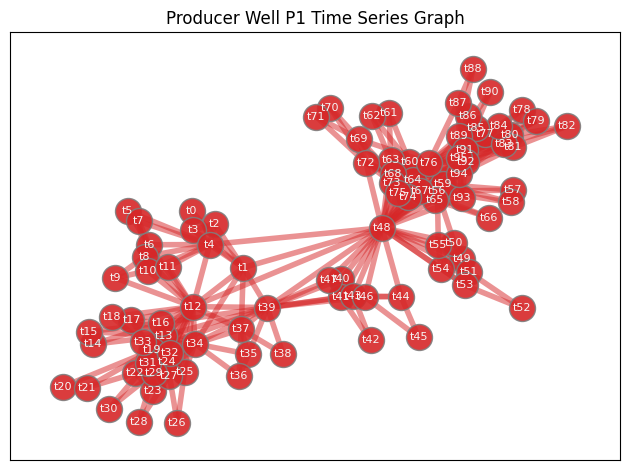

<Figure size 640x480 with 0 Axes>

P1 degree [(0, 1), (1, 9), (2, 3), (3, 3), (4, 11), (5, 2), (6, 5), (7, 3), (8, 7), (9, 3), (10, 5), (11, 4), (12, 23), (13, 13), (14, 3), (15, 3), (16, 8), (17, 5), (18, 3), (19, 18), (20, 2), (21, 3), (22, 10), (23, 4), (24, 11), (25, 9), (26, 2), (27, 12), (28, 2), (29, 12), (30, 2), (31, 11), (32, 11), (33, 7), (34, 18), (35, 4), (36, 3), (37, 7), (38, 2), (39, 15), (40, 6), (41, 7), (42, 2), (43, 8), (44, 4), (45, 2), (46, 8), (47, 6), (48, 35), (49, 2), (50, 6), (51, 6), (52, 2), (53, 4), (54, 5), (55, 5), (56, 20), (57, 3), (58, 3), (59, 15), (60, 13), (61, 3), (62, 3), (63, 7), (64, 14), (65, 10), (66, 2), (67, 12), (68, 10), (69, 6), (70, 3), (71, 3), (72, 9), (73, 13), (74, 11), (75, 11), (76, 20), (77, 11), (78, 4), (79, 4), (80, 13), (81, 10), (82, 3), (83, 10), (84, 8), (85, 12), (86, 6), (87, 6), (88, 2), (89, 15), (90, 2), (91, 13), (92, 17), (93, 6), (94, 14), (95, 22)]
P1 degree [(48, 35), (12, 23), (95, 22), (56, 20), (76, 20), (19, 18), (34, 18), (92, 17), (39, 15), 

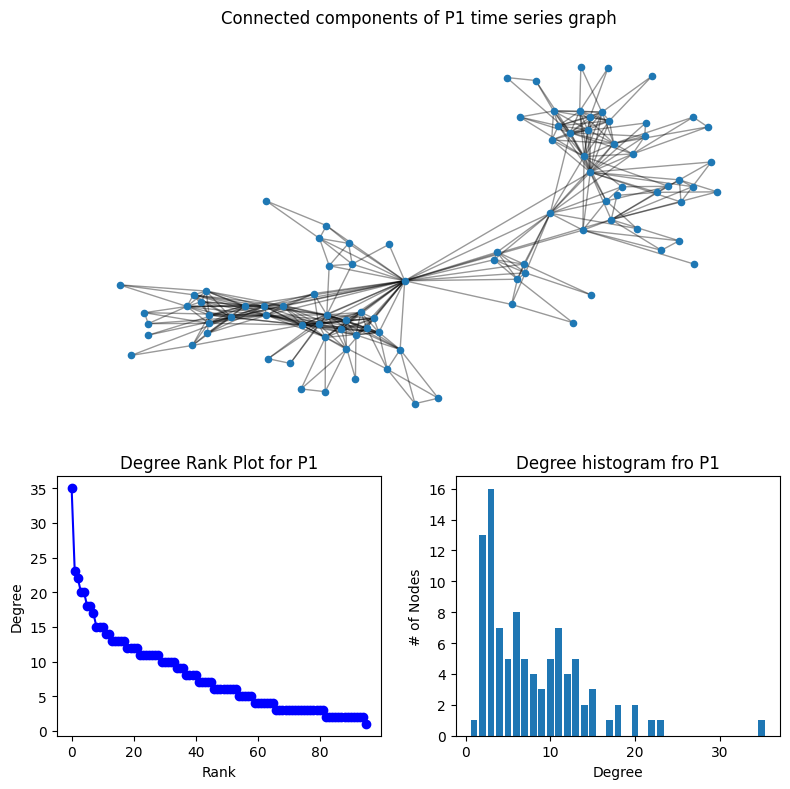

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526     0.003180 -0.008311              0.309446   
1        9           0.094737     0.041661  0.091967              0.446009   
2        3           0.031579     0.006506 -0.003805              0.317726   
3        3           0.031579     0.006506 -0.003805              0.317726   
4       11           0.115789     0.037065  0.048861              0.439815   
..     ...                ...          ...       ...                   ...   
91      13           0.136842     0.164024  0.020828              0.411255   
92      17           0.178947     0.234208  0.046881              0.422222   
93       6           0.063158     0.116553  0.029514              0.390947   
94      14           0.147368     0.213662  0.054613              0.414847   
95      22           0.231579     0.279692  0.064080              0.433790   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [11]:
import torch
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data

#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_P1 = production_injection["P1"]
data_P1.head()
#print(data_P1.head())
data_P1.shape
series_P1 = data_P1.values
#print(series_P1)
g1 = visibility_graph( series_P1 )
g1_edges = g1.edges()
print(g1.nodes())
#print(g1.edges())
print(g1_edges)
g1_edges
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(g1)
print(pyg_graph)
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(g1)
print(pyg_graph)
print(pyg_graph.x)
print(pyg_graph.y)
print(pyg_graph.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
gp1 = to_networkx(pyg_graph, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)

#print(gp1)

# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 350, "alpha": 0.9}
pos_P1 = nx.spring_layout(gp1, seed=3113794652)  # positions for all nodes
#pos_P1 = nx.draw_kamada_kawai(gp1, with_labels = True)

nx.draw_networkx_nodes(gp1, pos_P1, node_color="tab:red", **options)
# edges
nx.draw_networkx_edges(gp1, pos_P1, width=4.0, alpha=0.5, edge_color="tab:red")
# some math labels
labels = {}
labels[0] = r"t0"
labels[1] = r"t1"
labels[2] = r"t2"
labels[3] = r"t3"
labels[4] = r"t4"
labels[5] = r"t5"
labels[6] = r"t6"
labels[7] = r"t7"
labels[8] = r"t8"
labels[9] = r"t9"
labels[10] = r"t10"
labels[11] = r"t11"
labels[12] = r"t12"
labels[13] = r"t13"
labels[14] = r"t14"
labels[15] = r"t15"
labels[16] = r"t16"
labels[17] = r"t17"
labels[18] = r"t18"
labels[19] = r"t19"
labels[20] = r"t20"
labels[21] = r"t21"
labels[22] = r"t22"
labels[23] = r"t23"
labels[24] = r"t24"
labels[25] = r"t25"
labels[26] = r"t26"
labels[27] = r"t27"
labels[28] = r"t28"
labels[29] = r"t29"
labels[30] = r"t30"
labels[31] = r"t31"
labels[32] = r"t32"
labels[33] = r"t33"
labels[34] = r"t34"
labels[35] = r"t35"
labels[36] = r"t36"
labels[37] = r"t37"
labels[38] = r"t38"
labels[39] = r"t39"
labels[40] = r"t40"
labels[41] = r"t41"
labels[42] = r"t42"
labels[43] = r"t43"
labels[44] = r"t44"
labels[45] = r"t45"
labels[46] = r"t46"
labels[47] = r"t47"
labels[48] = r"t48"
labels[49] = r"t49"
labels[50] = r"t50"
labels[51] = r"t51"
labels[52] = r"t52"
labels[53] = r"t53"
labels[54] = r"t54"
labels[55] = r"t55"
labels[56] = r"t56"
labels[57] = r"t57"
labels[58] = r"t58"
labels[59] = r"t59"
labels[60] = r"t60"
labels[61] = r"t61"
labels[62] = r"t62"
labels[63] = r"t63"
labels[64] = r"t64"
labels[65] = r"t65"
labels[66] = r"t66"
labels[67] = r"t67"
labels[68] = r"t68"
labels[69] = r"t69"
labels[70] = r"t70"
labels[71] = r"t71"
labels[72] = r"t72"
labels[73] = r"t73"
labels[74] = r"t74"
labels[75] = r"t75"
labels[76] = r"t76"
labels[77] = r"t77"
labels[78] = r"t78"
labels[79] = r"t79"
labels[80] = r"t80"
labels[81] = r"t81"
labels[82] = r"t82"
labels[83] = r"t83"
labels[84] = r"t84"
labels[85] = r"t85"
labels[86] = r"t86"
labels[87] = r"t87"
labels[88] = r"t88"
labels[89] = r"t89"
labels[90] = r"t90"
labels[91] = r"t91"
labels[92] = r"t92"
labels[93] = r"t93"
labels[94] = r"t94"
labels[95] = r"t95"
#labels[96] = r"t96"
#labels[97] = r"t97"
nx.draw_networkx_labels(gp1, pos_P1, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well P1 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_P1.png")
plt.show()
print("P1 degree", gp1.degree)
print("P1 degree", sorted(gp1.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())




degree_sequence_P1 = sorted((d for n, d in gp1.degree()), reverse=True)
print("Degree_sequence_P1", degree_sequence_P1)
dmax_P1 = max(degree_sequence_P1)
print(dmax_P1)

fig = plt.figure("Degree of P1 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gp1.subgraph(sorted(nx.connected_components(gp1), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of P1 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_P1, "b-", marker="o")
ax1.set_title("Degree Rank Plot for P1")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_P1, return_counts=True))
ax2.set_title("Degree histogram fro P1")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_gp1_characteristics = pd.DataFrame(dict(
    DEGREE = dict(gp1.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(gp1),
    EIGENVECTOR = nx.eigenvector_centrality(gp1),
    KATZ = nx.katz_centrality_numpy(gp1),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(gp1),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(gp1),
    CLUSTCOEF = nx.clustering(gp1),
)) 

print(ts_gp1_characteristics)


edges_df_gp1 = nx.to_pandas_edgelist(gp1, nodelist=labels)
print("VG_edges P1")
print(edges_df_gp1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 774], mag=[96], num_nodes=96)
Data(edge_index=[2, 774], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  0,  1,  ..., 95, 95, 95],
        [ 1,  4,  0,  ..., 89, 92, 93]])


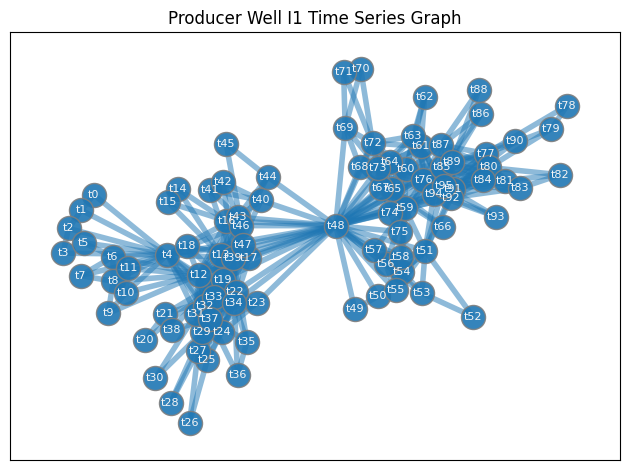

<Figure size 640x480 with 0 Axes>

I1 degree [(0, 2), (1, 3), (2, 3), (3, 2), (4, 21), (5, 2), (6, 5), (7, 3), (8, 7), (9, 3), (10, 5), (11, 4), (12, 25), (13, 17), (14, 3), (15, 3), (16, 7), (17, 11), (18, 3), (19, 16), (20, 2), (21, 3), (22, 15), (23, 8), (24, 10), (25, 8), (26, 2), (27, 10), (28, 2), (29, 13), (30, 2), (31, 13), (32, 13), (33, 11), (34, 19), (35, 4), (36, 3), (37, 7), (38, 2), (39, 17), (40, 5), (41, 4), (42, 4), (43, 11), (44, 4), (45, 2), (46, 11), (47, 11), (48, 43), (49, 2), (50, 3), (51, 12), (52, 2), (53, 4), (54, 6), (55, 4), (56, 6), (57, 4), (58, 3), (59, 17), (60, 18), (61, 10), (62, 3), (63, 9), (64, 11), (65, 8), (66, 2), (67, 9), (68, 8), (69, 6), (70, 3), (71, 3), (72, 13), (73, 13), (74, 6), (75, 3), (76, 21), (77, 12), (78, 2), (79, 3), (80, 14), (81, 8), (82, 3), (83, 6), (84, 10), (85, 10), (86, 3), (87, 8), (88, 2), (89, 16), (90, 2), (91, 12), (92, 17), (93, 3), (94, 12), (95, 18)]
I1 degree [(48, 43), (12, 25), (4, 21), (76, 21), (34, 19), (60, 18), (95, 18), (13, 17), (39, 17), 

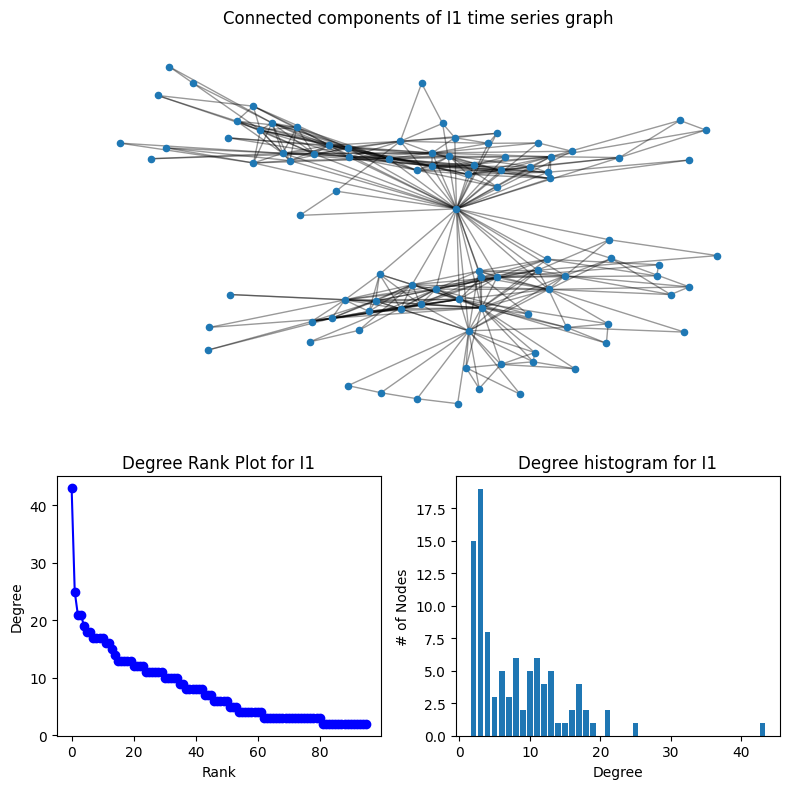

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        2           0.021053     0.012064 -0.034275              0.327586   
1        3           0.031579     0.012967 -0.037703              0.328720   
2        3           0.031579     0.012967 -0.037703              0.328720   
3        2           0.021053     0.012064 -0.034275              0.327586   
4       21           0.221053     0.148173  0.118004              0.482234   
..     ...                ...          ...       ...                   ...   
91      12           0.126316     0.135890  0.122757              0.437788   
92      17           0.178947     0.178603  0.171050              0.448113   
93       3           0.031579     0.037757  0.006063              0.314570   
94      12           0.126316     0.141189  0.134655              0.431818   
95      18           0.189474     0.184557  0.177975              0.450237   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [12]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_I1 = production_injection["I1"]
data_I1.head()
#print(data_P1.head())
data_I1.shape
series_I1 = data_I1.values
#print(series_P1)
g_I1 = visibility_graph( series_I1 )
g_I1_edges = g_I1.edges()
print(g_I1.nodes())
#print(g1.edges())
#print(g1_edges)
g_I1_edges
# Convert the graph into PyTorch geometric
pyg_graph_I1 = from_networkx(g_I1)
print(pyg_graph_I1)
# Convert the graph into PyTorch geometric
pyg_graph_I1 = from_networkx(g_I1)
print(pyg_graph_I1)
print(pyg_graph_I1.x)
print(pyg_graph_I1.y)
print(pyg_graph_I1.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_I1 = to_networkx(pyg_graph_I1, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_I1 = nx.spring_layout(g_I1, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_I1, pos_I1, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_I1, pos_I1, width=4.0, alpha=0.5, edge_color="tab:blue")

nx.draw_networkx_labels(g_I1, pos_I1, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well I1 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_I1.png")
plt.show()
print("I1 degree", g_I1.degree)
print("I1 degree", sorted(g_I1.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()



degree_sequence_I1 = sorted((d for n, d in g_I1.degree()), reverse=True)
print("Degree_sequence_I1", degree_sequence_I1)
dmax_I1 = max(degree_sequence_I1)
print(dmax_I1)

fig = plt.figure("Degree of I1 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_I1.subgraph(sorted(nx.connected_components(g_I1), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of I1 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_I1, "b-", marker="o")
ax1.set_title("Degree Rank Plot for I1")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_I1, return_counts=True))
ax2.set_title("Degree histogram for I1")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_I1_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_I1.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_I1),
    EIGENVECTOR = nx.eigenvector_centrality(g_I1),
    KATZ = nx.katz_centrality_numpy(g_I1),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_I1),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_I1),
    CLUSTCOEF = nx.clustering(g_I1),
)) 

print(ts_g_I1_characteristics)


edges_df_g_I1 = nx.to_pandas_edgelist(g_I1, nodelist=labels)
print("VG_edges I1")
print(edges_df_g_I1)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 704], mag=[96], num_nodes=96)
Data(edge_index=[2, 704], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 95, 95, 95],
        [ 1,  0,  2,  ..., 90, 92, 93]])


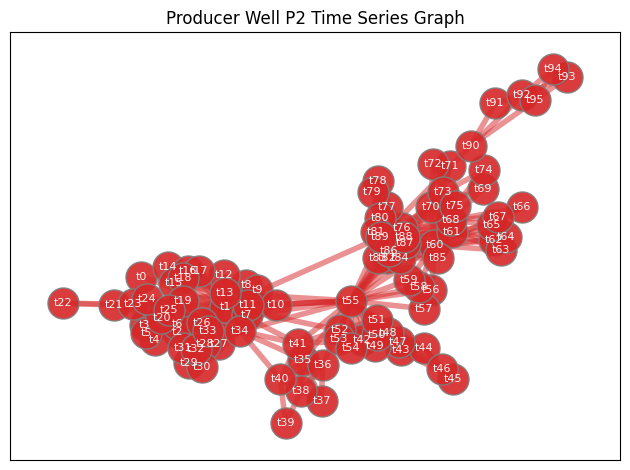

<Figure size 640x480 with 0 Axes>

P2 degree [(0, 1), (1, 32), (2, 6), (3, 5), (4, 5), (5, 5), (6, 6), (7, 10), (8, 4), (9, 4), (10, 7), (11, 10), (12, 3), (13, 13), (14, 6), (15, 6), (16, 7), (17, 5), (18, 7), (19, 15), (20, 8), (21, 6), (22, 2), (23, 7), (24, 6), (25, 8), (26, 12), (27, 6), (28, 8), (29, 6), (30, 5), (31, 7), (32, 8), (33, 14), (34, 18), (35, 7), (36, 6), (37, 3), (38, 6), (39, 2), (40, 6), (41, 9), (42, 8), (43, 9), (44, 5), (45, 3), (46, 4), (47, 7), (48, 7), (49, 5), (50, 7), (51, 3), (52, 12), (53, 3), (54, 3), (55, 33), (56, 4), (57, 3), (58, 5), (59, 3), (60, 22), (61, 12), (62, 5), (63, 4), (64, 5), (65, 7), (66, 3), (67, 4), (68, 12), (69, 2), (70, 12), (71, 3), (72, 3), (73, 7), (74, 2), (75, 7), (76, 19), (77, 7), (78, 3), (79, 4), (80, 8), (81, 8), (82, 9), (83, 8), (84, 10), (85, 3), (86, 10), (87, 16), (88, 11), (89, 16), (90, 4), (91, 2), (92, 5), (93, 3), (94, 3), (95, 4)]
P2 degree [(55, 33), (1, 32), (60, 22), (76, 19), (34, 18), (87, 16), (89, 16), (19, 15), (33, 14), (13, 13), (26, 

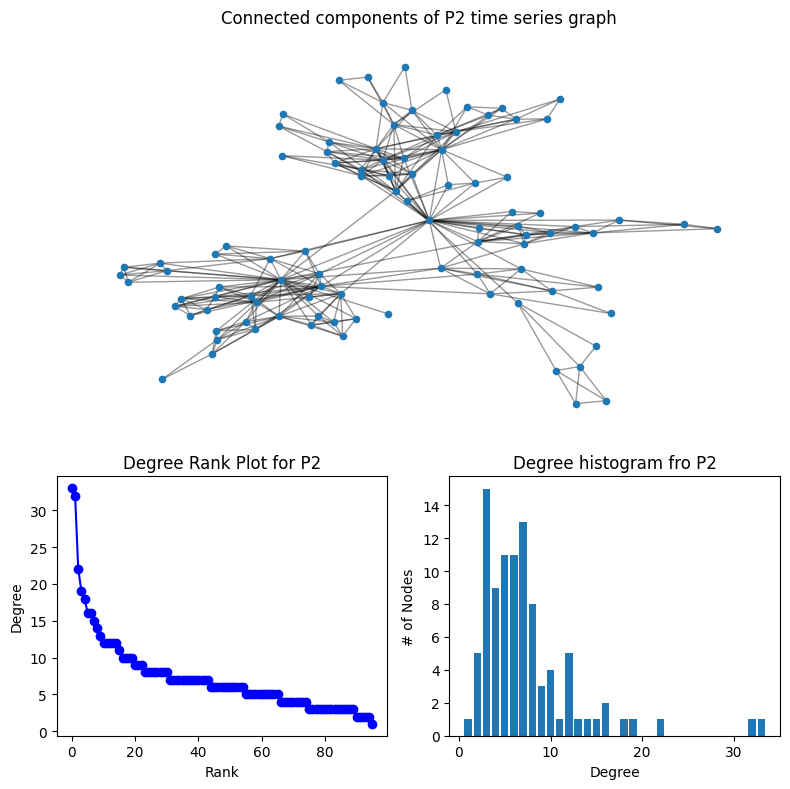

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526     0.021049  0.032486              0.340502   
1       32           0.336842     0.242993  0.404798              0.513514   
2        6           0.063158     0.043281  0.074339              0.346715   
3        5           0.052632     0.034530  0.059192              0.345455   
4        5           0.052632     0.034530  0.059192              0.345455   
..     ...                ...          ...       ...                   ...   
91       2           0.021053     0.002133 -0.010895              0.260274   
92       5           0.052632     0.002378 -0.014275              0.262431   
93       3           0.031579     0.000435 -0.011944              0.209251   
94       3           0.031579     0.000435 -0.011944              0.209251   
95       4           0.042105     0.002208 -0.013284              0.261708   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [13]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_P2 = production_injection["P2"]
data_P2.head()
#print(data_P1.head())
data_P2.shape
series_P2 = data_P2.values
#print(series_P1)
g_P2 = visibility_graph( series_P2 )
g_P2_edges = g_P2.edges()
print(g_P2.nodes())
#print(g1.edges())
#print(g1_edges)
g_P2_edges
# Convert the graph into PyTorch geometric
pyg_graph_P2 = from_networkx(g_P2)
print(pyg_graph_P2)
# Convert the graph into PyTorch geometric
pyg_graph_P2 = from_networkx(g_P2)
print(pyg_graph_P2)
print(pyg_graph_P2.x)
print(pyg_graph_P2.y)
print(pyg_graph_P2.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_P2 = to_networkx(pyg_graph_P2, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 500, "alpha": 0.9}
pos_P2 = nx.spring_layout(g_P2, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_P2, pos_P2, node_color="tab:red", **options)
# edges
nx.draw_networkx_edges(g_P2, pos_P2, width=4.0, alpha=0.5, edge_color="tab:red")

nx.draw_networkx_labels(g_P2, pos_P2, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well P2 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_P2.png")
plt.show()
print("P2 degree", g_P2.degree)
print("P2 degree", sorted(g_P2.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()



degree_sequence_P2 = sorted((d for n, d in g_P2.degree()), reverse=True)
print("Degree_sequence_P2", degree_sequence_P2)
dmax_P2 = max(degree_sequence_P2)
print(dmax_P2)

fig = plt.figure("Degree of P2 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_P2.subgraph(sorted(nx.connected_components(g_P2), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of P2 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_P2, "b-", marker="o")
ax1.set_title("Degree Rank Plot for P2")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_P2, return_counts=True))
ax2.set_title("Degree histogram fro P2")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_P2_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_P2.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_P2),
    EIGENVECTOR = nx.eigenvector_centrality(g_P2),
    KATZ = nx.katz_centrality_numpy(g_P2),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_P2),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_P2),
    CLUSTCOEF = nx.clustering(g_P2),
)) 

print(ts_g_P2_characteristics)


edges_df_g_P2 = nx.to_pandas_edgelist(g_P2, nodelist=labels)
print("VG_edges P2")
print(edges_df_g_P2)

print(len(edges_df_gp1))
print(len(edges_df_g_P2))

joining_edges_P1_P2=edges_df_gp1.join(edges_df_g_P2, lsuffix='_P1', rsuffix='_P2')
print(joining_edges_P1_P2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 790], mag=[96], num_nodes=96)
Data(edge_index=[2, 790], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 95, 95, 95],
        [ 1,  0,  2,  ..., 86, 87, 93]])


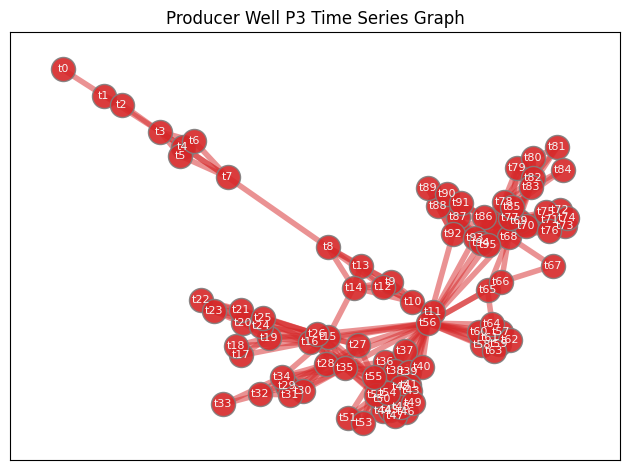

<Figure size 640x480 with 0 Axes>

P3 degree [(0, 1), (1, 3), (2, 2), (3, 6), (4, 4), (5, 4), (6, 4), (7, 5), (8, 5), (9, 6), (10, 4), (11, 3), (12, 6), (13, 4), (14, 6), (15, 12), (16, 10), (17, 3), (18, 3), (19, 8), (20, 6), (21, 6), (22, 3), (23, 5), (24, 7), (25, 9), (26, 11), (27, 6), (28, 11), (29, 6), (30, 5), (31, 6), (32, 5), (33, 2), (34, 8), (35, 16), (36, 7), (37, 4), (38, 12), (39, 8), (40, 6), (41, 16), (42, 13), (43, 13), (44, 11), (45, 9), (46, 12), (47, 9), (48, 11), (49, 10), (50, 16), (51, 3), (52, 17), (53, 3), (54, 18), (55, 26), (56, 30), (57, 8), (58, 8), (59, 8), (60, 6), (61, 8), (62, 7), (63, 7), (64, 9), (65, 4), (66, 4), (67, 2), (68, 23), (69, 17), (70, 14), (71, 8), (72, 7), (73, 7), (74, 7), (75, 9), (76, 5), (77, 13), (78, 12), (79, 5), (80, 5), (81, 3), (82, 6), (83, 10), (84, 2), (85, 12), (86, 13), (87, 8), (88, 6), (89, 4), (90, 6), (91, 7), (92, 10), (93, 13), (94, 11), (95, 11)]
P3 degree [(56, 30), (55, 26), (68, 23), (54, 18), (52, 17), (69, 17), (35, 16), (41, 16), (50, 16), (70,

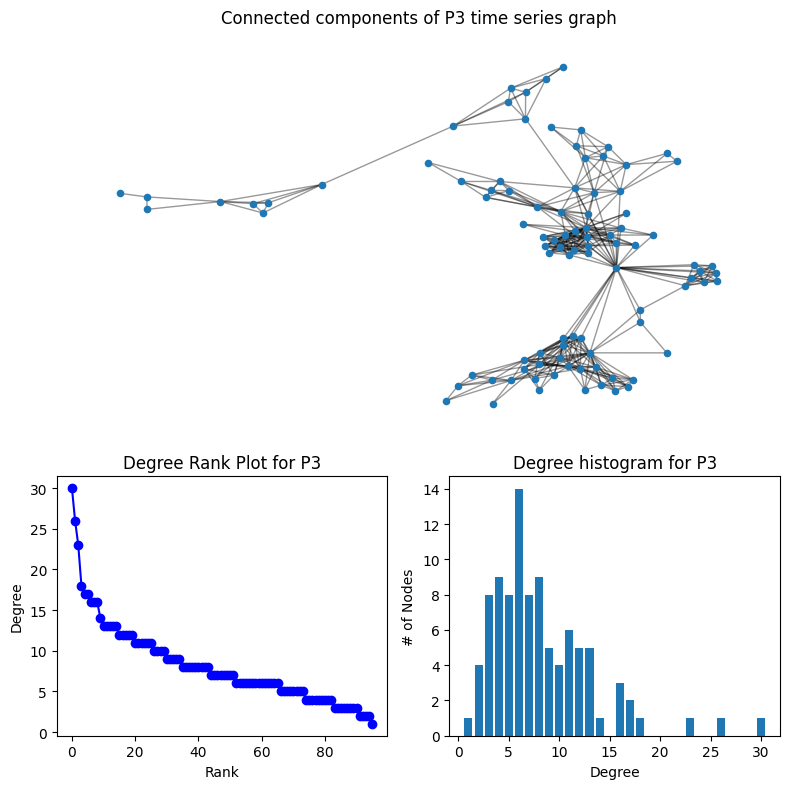

Creating histogram...
Creating histogram...
    DEGREE  DEGREE_CENTRALITY   EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526  4.103264e-08 -0.025446              0.132682   
1        3           0.031579  5.290467e-07 -0.032191              0.152733   
2        2           0.021053  5.260932e-07 -0.029877              0.152488   
3        6           0.063158  6.254040e-06 -0.044309              0.178908   
4        4           0.042105  6.178094e-06 -0.038667              0.177903   
..     ...                ...           ...       ...                   ...   
91       7           0.073684  1.441524e-02  0.064176              0.288754   
92      10           0.105263  3.743195e-02  0.125709              0.362595   
93      13           0.136842  5.224182e-02  0.244405              0.371094   
94      11           0.115789  4.876830e-02  0.229815              0.366795   
95      11           0.115789  4.876830e-02  0.229815              0.366795   

    BET

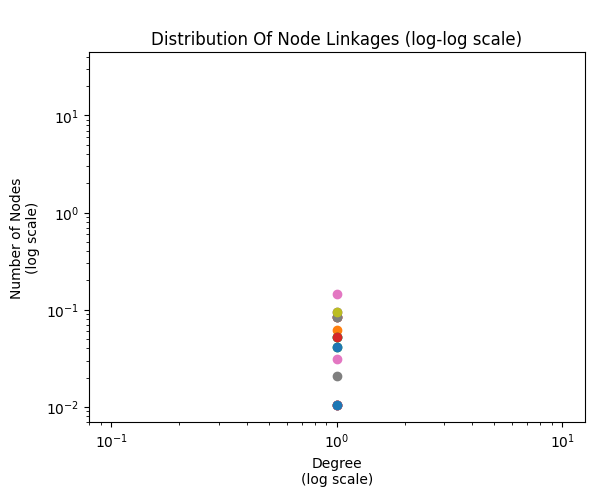

In [14]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_P3 = production_injection["P3"]
data_P3.head()
#print(data_P1.head())
data_P3.shape
series_P3 = data_P3.values
#print(series_P1)
g_P3 = visibility_graph( series_P3 )
g_P3_edges = g_P3.edges()
print(g_P3.nodes())
#print(g1.edges())
#print(g1_edges)
g_P3_edges
# Convert the graph into PyTorch geometric
pyg_graph_P3 = from_networkx(g_P3)
print(pyg_graph_P3)
# Convert the graph into PyTorch geometric
pyg_graph_P3 = from_networkx(g_P3)
print(pyg_graph_P3)
print(pyg_graph_P3.x)
print(pyg_graph_P3.y)
print(pyg_graph_P3.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_P3 = to_networkx(pyg_graph_P3, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_P3 = nx.spring_layout(g_P3, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_P3, pos_P3, node_color="tab:red", **options)
# edges
nx.draw_networkx_edges(g_P3, pos_P3, width=4.0, alpha=0.5, edge_color="tab:red")

nx.draw_networkx_labels(g_P3, pos_P3, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well P3 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_P3.png")
plt.show()
print("P3 degree", g_P3.degree)
print("P3 degree", sorted(g_P3.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()




degree_sequence_P3 = sorted((d for n, d in g_P3.degree()), reverse=True)
print("Degree_sequence_P3", degree_sequence_P3)
dmax_P3 = max(degree_sequence_P3)
print(dmax_P3)

fig = plt.figure("Degree of P3 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_P3.subgraph(sorted(nx.connected_components(g_P3), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of P3 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_P3, "b-", marker="o")
ax1.set_title("Degree Rank Plot for P3")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_P3, return_counts=True))
ax2.set_title("Degree histogram for P3")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y


plot_degree_histogram(g_P3)
plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
#plt.plot(aux_x, aux_y, 'o')
plt.plot(plot_degree_histogram(g_P3), 'o')



ts_g_P3_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_P3.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_P3),
    EIGENVECTOR = nx.eigenvector_centrality(g_P3),
    KATZ = nx.katz_centrality_numpy(g_P3),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_P3),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_P3),
    CLUSTCOEF = nx.clustering(g_P3),
)) 

print(ts_g_P3_characteristics)


edges_df_g_P3 = nx.to_pandas_edgelist(g_P3, nodelist=labels)
print("VG_edges P3")
print(edges_df_g_P3)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 672], mag=[96], num_nodes=96)
Data(edge_index=[2, 672], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 95, 95, 95],
        [ 1,  0,  2,  ..., 94, 92, 93]])


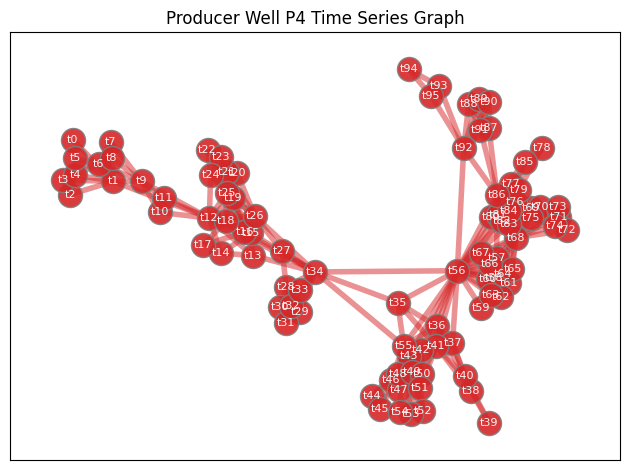

<Figure size 640x480 with 0 Axes>

P4 degree [(0, 1), (1, 9), (2, 3), (3, 3), (4, 5), (5, 3), (6, 6), (7, 3), (8, 4), (9, 7), (10, 3), (11, 3), (12, 14), (13, 4), (14, 3), (15, 9), (16, 8), (17, 2), (18, 7), (19, 10), (20, 6), (21, 7), (22, 4), (23, 6), (24, 7), (25, 11), (26, 10), (27, 3), (28, 6), (29, 4), (30, 5), (31, 3), (32, 6), (33, 3), (34, 15), (35, 5), (36, 6), (37, 6), (38, 4), (39, 2), (40, 5), (41, 11), (42, 10), (43, 10), (44, 3), (45, 3), (46, 9), (47, 4), (48, 6), (49, 7), (50, 7), (51, 8), (52, 3), (53, 4), (54, 3), (55, 17), (56, 27), (57, 11), (58, 10), (59, 3), (60, 10), (61, 7), (62, 7), (63, 7), (64, 10), (65, 4), (66, 8), (67, 5), (68, 24), (69, 11), (70, 9), (71, 7), (72, 5), (73, 7), (74, 7), (75, 14), (76, 10), (77, 9), (78, 2), (79, 9), (80, 9), (81, 9), (82, 12), (83, 10), (84, 12), (85, 2), (86, 17), (87, 6), (88, 4), (89, 5), (90, 4), (91, 6), (92, 9), (93, 3), (94, 2), (95, 3)]
P4 degree [(56, 27), (68, 24), (55, 17), (86, 17), (34, 15), (12, 14), (75, 14), (82, 12), (84, 12), (25, 11), (4

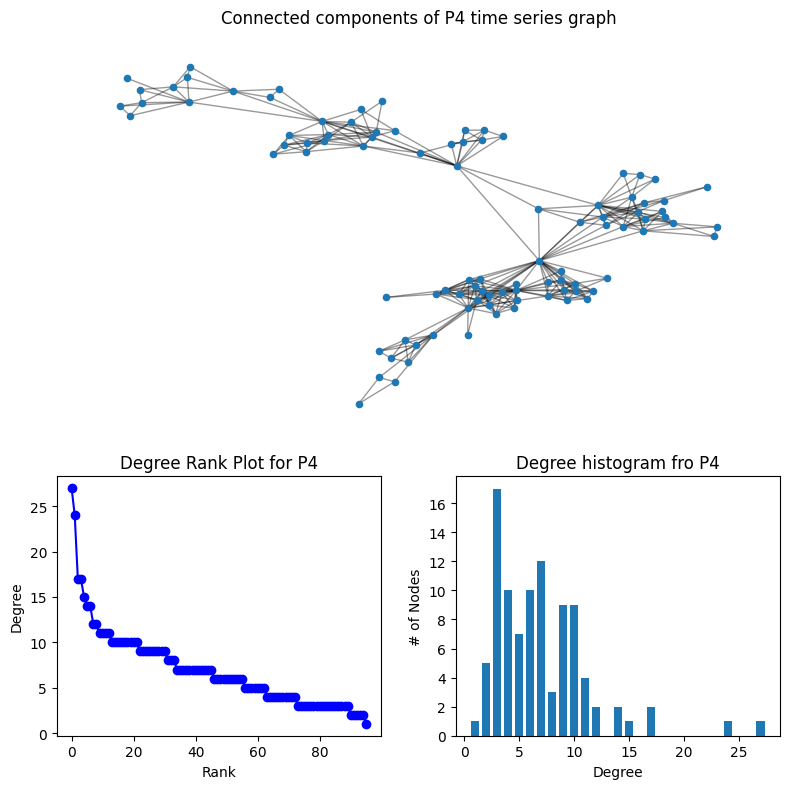

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526     0.000084 -0.023618              0.218894   
1        9           0.094737     0.000947 -0.058815              0.279412   
2        3           0.031579     0.000106 -0.030368              0.219907   
3        3           0.031579     0.000106 -0.030368              0.219907   
4        5           0.052632     0.000134 -0.037127              0.221445   
..     ...                ...          ...       ...                   ...   
91       6           0.063158     0.036551  0.006463              0.281065   
92       9           0.094737     0.063167  0.023186              0.355805   
93       3           0.031579     0.006284 -0.019536              0.265363   
94       2           0.021053     0.001119 -0.021644              0.210643   
95       3           0.031579     0.006284 -0.019536              0.265363   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [15]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_P4 = production_injection["P4"]
data_P4.head()
#print(data_P1.head())
data_P4.shape
series_P4 = data_P4.values
#print(series_P1)
g_P4 = visibility_graph( series_P4 )
g_P4_edges = g_P4.edges()
print(g_P4.nodes())
#print(g1.edges())
#print(g1_edges)
g_P4_edges
# Convert the graph into PyTorch geometric
pyg_graph_P4 = from_networkx(g_P4)
print(pyg_graph_P4)
# Convert the graph into PyTorch geometric
pyg_graph_P4 = from_networkx(g_P4)
print(pyg_graph_P4)
print(pyg_graph_P4.x)
print(pyg_graph_P4.y)
print(pyg_graph_P4.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_P4 = to_networkx(pyg_graph_P4, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_P4 = nx.spring_layout(g_P4, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_P4, pos_P4, node_color="tab:red", **options)
# edges
nx.draw_networkx_edges(g_P4, pos_P4, width=4.0, alpha=0.5, edge_color="tab:red")

nx.draw_networkx_labels(g_P4, pos_P4, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well P4 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_P4.png")
plt.show()
print("P4 degree", g_P4.degree)
print("P4 degree", sorted(g_P4.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()



degree_sequence_P4 = sorted((d for n, d in g_P4.degree()), reverse=True)
print("Degree_sequence_P4", degree_sequence_P4)
dmax_P4 = max(degree_sequence_P4)
print(dmax_P4)

fig = plt.figure("Degree of P4 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_P4.subgraph(sorted(nx.connected_components(g_P4), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of P4 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_P4, "b-", marker="o")
ax1.set_title("Degree Rank Plot for P4")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_P4, return_counts=True))
ax2.set_title("Degree histogram fro P4")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


ts_g_P4_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_P4.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_P4),
    EIGENVECTOR = nx.eigenvector_centrality(g_P4),
    KATZ = nx.katz_centrality_numpy(g_P4),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_P4),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_P4),
    CLUSTCOEF = nx.clustering(g_P4),
)) 

print(ts_g_P4_characteristics)


edges_df_g_P4 = nx.to_pandas_edgelist(g_P4, nodelist=labels)
print("VG_edges P4")
print(edges_df_g_P4)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 668], mag=[96], num_nodes=96)
Data(edge_index=[2, 668], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 95, 95, 95],
        [ 1,  0,  2,  ..., 88, 91, 93]])


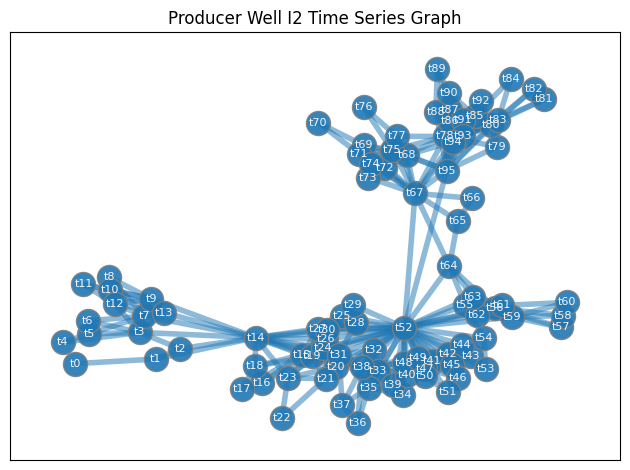

<Figure size 640x480 with 0 Axes>

I2 degree [(0, 1), (1, 3), (2, 3), (3, 8), (4, 2), (5, 4), (6, 3), (7, 8), (8, 2), (9, 7), (10, 4), (11, 3), (12, 6), (13, 6), (14, 17), (15, 12), (16, 4), (17, 3), (18, 5), (19, 14), (20, 5), (21, 6), (22, 2), (23, 6), (24, 13), (25, 3), (26, 9), (27, 10), (28, 5), (29, 4), (30, 9), (31, 14), (32, 4), (33, 6), (34, 3), (35, 7), (36, 3), (37, 4), (38, 19), (39, 3), (40, 8), (41, 12), (42, 8), (43, 5), (44, 5), (45, 9), (46, 4), (47, 10), (48, 7), (49, 9), (50, 10), (51, 2), (52, 42), (53, 2), (54, 3), (55, 7), (56, 9), (57, 3), (58, 3), (59, 8), (60, 2), (61, 7), (62, 6), (63, 7), (64, 6), (65, 3), (66, 2), (67, 16), (68, 10), (69, 6), (70, 2), (71, 7), (72, 6), (73, 4), (74, 7), (75, 11), (76, 2), (77, 5), (78, 14), (79, 3), (80, 11), (81, 3), (82, 3), (83, 9), (84, 2), (85, 11), (86, 7), (87, 9), (88, 7), (89, 3), (90, 7), (91, 11), (92, 4), (93, 12), (94, 12), (95, 15)]
I2 degree [(52, 42), (38, 19), (14, 17), (67, 16), (95, 15), (19, 14), (31, 14), (78, 14), (24, 13), (15, 12), (41

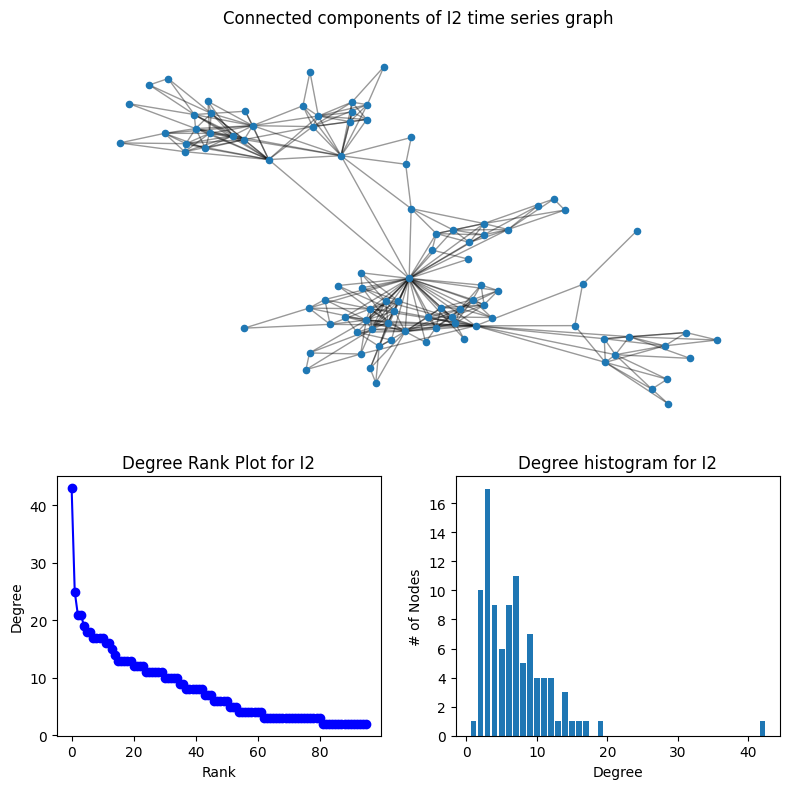

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526     0.001898 -0.010153              0.238693   
1        3           0.031579     0.021424  0.004631              0.312500   
2        3           0.031579     0.023594  0.005654              0.316667   
3        8           0.084211     0.028558  0.001100              0.324232   
4        2           0.021053     0.003050 -0.011784              0.246114   
..     ...                ...          ...       ...                   ...   
91      11           0.115789     0.032918 -0.203368              0.333333   
92       4           0.042105     0.012949 -0.094008              0.265363   
93      12           0.126316     0.040209 -0.219349              0.345455   
94      12           0.126316     0.041783 -0.223857              0.345455   
95      15           0.157895     0.082091 -0.216661              0.456731   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [16]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_I2 = production_injection["I2"]
data_I2.head()
#print(data_P1.head())
data_I2.shape
series_I2 = data_I2.values
#print(series_P1)
g_I2 = visibility_graph( series_I2 )
g_I2_edges = g_I2.edges()
print(g_I2.nodes())
#print(g1.edges())
#print(g1_edges)
g_I2_edges
# Convert the graph into PyTorch geometric
pyg_graph_I2 = from_networkx(g_I2)
print(pyg_graph_I2)
# Convert the graph into PyTorch geometric
pyg_graph_I2 = from_networkx(g_I2)
print(pyg_graph_I2)
print(pyg_graph_I2.x)
print(pyg_graph_I2.y)
print(pyg_graph_I2.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_I2 = to_networkx(pyg_graph_I2, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_I2 = nx.spring_layout(g_I2, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_I2, pos_I2, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_I2, pos_I2, width=4.0, alpha=0.5, edge_color="tab:blue")
# some math labels

nx.draw_networkx_labels(g_I2, pos_I2, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well I2 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_I2.png")
plt.show()
print("I2 degree", g_I2.degree)
print("I2 degree", sorted(g_I2.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()


degree_sequence_I2 = sorted((d for n, d in g_I2.degree()), reverse=True)
print("Degree_sequence_I2", degree_sequence_I2)
dmax_I2 = max(degree_sequence_I2)
print(dmax_I2)

fig = plt.figure("Degree of I2 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_I2.subgraph(sorted(nx.connected_components(g_I2), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of I2 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_I1, "b-", marker="o")
ax1.set_title("Degree Rank Plot for I2")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_I2, return_counts=True))
ax2.set_title("Degree histogram for I2")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_I2_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_I2.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_I2),
    EIGENVECTOR = nx.eigenvector_centrality(g_I2),
    KATZ = nx.katz_centrality_numpy(g_I2),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_I2),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_I2),
    CLUSTCOEF = nx.clustering(g_I2),
)) 

print(ts_g_I2_characteristics)


edges_df_g_I2 = nx.to_pandas_edgelist(g_I2, nodelist=labels)
print("VG_edges I2")
print(edges_df_g_I2)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 708], mag=[96], num_nodes=96)
Data(edge_index=[2, 708], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 94, 95, 95],
        [ 1,  0,  2,  ..., 95, 94, 93]])


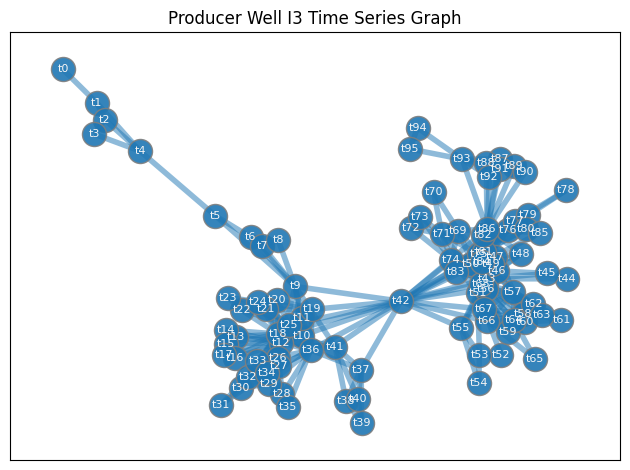

<Figure size 640x480 with 0 Axes>

I3 degree [(0, 1), (1, 3), (2, 3), (3, 2), (4, 4), (5, 3), (6, 4), (7, 3), (8, 3), (9, 10), (10, 3), (11, 3), (12, 19), (13, 4), (14, 4), (15, 6), (16, 4), (17, 4), (18, 19), (19, 7), (20, 4), (21, 6), (22, 5), (23, 3), (24, 6), (25, 14), (26, 4), (27, 10), (28, 4), (29, 8), (30, 6), (31, 3), (32, 8), (33, 8), (34, 13), (35, 2), (36, 14), (37, 6), (38, 4), (39, 3), (40, 4), (41, 8), (42, 20), (43, 18), (44, 2), (45, 3), (46, 16), (47, 11), (48, 5), (49, 13), (50, 10), (51, 14), (52, 2), (53, 4), (54, 2), (55, 6), (56, 19), (57, 13), (58, 10), (59, 6), (60, 10), (61, 4), (62, 8), (63, 6), (64, 11), (65, 2), (66, 10), (67, 11), (68, 22), (69, 6), (70, 2), (71, 7), (72, 3), (73, 3), (74, 14), (75, 20), (76, 7), (77, 8), (78, 2), (79, 6), (80, 5), (81, 17), (82, 4), (83, 7), (84, 18), (85, 2), (86, 26), (87, 6), (88, 5), (89, 5), (90, 4), (91, 7), (92, 3), (93, 7), (94, 2), (95, 2)]
I3 degree [(86, 26), (68, 22), (42, 20), (75, 20), (12, 19), (18, 19), (56, 19), (43, 18), (84, 18), (81, 17

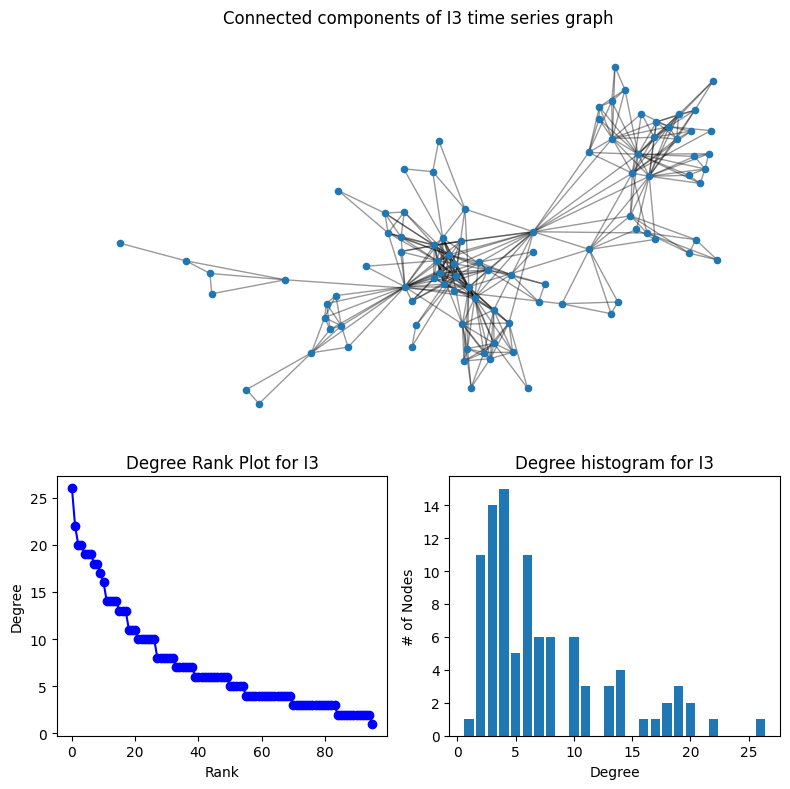

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        1           0.010526     0.000001  0.016758              0.160202   
1        3           0.031579     0.000013  0.020865              0.190381   
2        3           0.031579     0.000014  0.021087              0.190381   
3        2           0.021053     0.000013  0.019190              0.189621   
4        4           0.042105     0.000160  0.024098              0.232843   
..     ...                ...          ...       ...                   ...   
91       7           0.073684     0.035082  0.007687              0.317726   
92       3           0.031579     0.026334  0.005332              0.313531   
93       7           0.073684     0.031229  0.009755              0.317726   
94       2           0.021053     0.002558  0.017385              0.242347   
95       2           0.021053     0.002558  0.017385              0.242347   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [17]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_I3 = production_injection["I3"]
data_I3.head()
#print(data_P1.head())
data_I3.shape
series_I3 = data_I3.values
#print(series_P1)
g_I3 = visibility_graph( series_I3 )
g_I3_edges = g_I3.edges()
print(g_I3.nodes())
#print(g1.edges())
#print(g1_edges)
g_I3_edges
# Convert the graph into PyTorch geometric
pyg_graph_I3 = from_networkx(g_I3)
print(pyg_graph_I3)
# Convert the graph into PyTorch geometric
pyg_graph_I3 = from_networkx(g_I3)
print(pyg_graph_I3)
print(pyg_graph_I3.x)
print(pyg_graph_I3.y)
print(pyg_graph_I3.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_I3 = to_networkx(pyg_graph_I3, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_I3 = nx.spring_layout(g_I3, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_I3, pos_I3, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_I3, pos_I3, width=4.0, alpha=0.5, edge_color="tab:blue")
# some math labels

nx.draw_networkx_labels(g_I3, pos_I3, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well I3 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_I3.png")
plt.show()
print("I3 degree", g_I3.degree)
print("I3 degree", sorted(g_I3.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()


degree_sequence_I3 = sorted((d for n, d in g_I3.degree()), reverse=True)
print("Degree_sequence_I3", degree_sequence_I3)
dmax_I3 = max(degree_sequence_I3)
print(dmax_I3)

fig = plt.figure("Degree of I3 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_I3.subgraph(sorted(nx.connected_components(g_I3), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of I3 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_I3, "b-", marker="o")
ax1.set_title("Degree Rank Plot for I3")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_I3, return_counts=True))
ax2.set_title("Degree histogram for I3")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_I3_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_I3.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_I3),
    EIGENVECTOR = nx.eigenvector_centrality(g_I3),
    KATZ = nx.katz_centrality_numpy(g_I3),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_I3),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_I3),
    CLUSTCOEF = nx.clustering(g_I3),
)) 

print(ts_g_I3_characteristics)


edges_df_g_I3 = nx.to_pandas_edgelist(g_I3, nodelist=labels)
print("VG_edges I3")
print(edges_df_g_I3)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 580], mag=[96], num_nodes=96)
Data(edge_index=[2, 580], mag=[96], num_nodes=96)
None
None
edge index
tensor([[ 0,  1,  1,  ..., 95, 95, 95],
        [ 1,  0,  2,  ..., 91, 92, 93]])


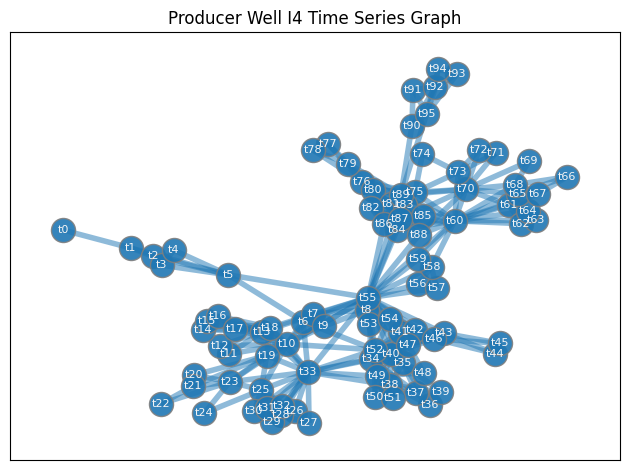

<Figure size 640x480 with 0 Axes>

I4 degree [(0, 1), (1, 3), (2, 3), (3, 3), (4, 2), (5, 6), (6, 6), (7, 4), (8, 2), (9, 3), (10, 14), (11, 3), (12, 3), (13, 10), (14, 4), (15, 4), (16, 5), (17, 4), (18, 9), (19, 8), (20, 3), (21, 4), (22, 2), (23, 8), (24, 2), (25, 10), (26, 6), (27, 3), (28, 8), (29, 5), (30, 5), (31, 7), (32, 6), (33, 20), (34, 7), (35, 7), (36, 3), (37, 4), (38, 7), (39, 2), (40, 12), (41, 6), (42, 7), (43, 7), (44, 3), (45, 3), (46, 9), (47, 9), (48, 3), (49, 7), (50, 3), (51, 3), (52, 18), (53, 3), (54, 3), (55, 28), (56, 3), (57, 3), (58, 5), (59, 3), (60, 19), (61, 7), (62, 4), (63, 4), (64, 5), (65, 7), (66, 3), (67, 4), (68, 7), (69, 2), (70, 12), (71, 3), (72, 3), (73, 6), (74, 2), (75, 11), (76, 9), (77, 3), (78, 3), (79, 5), (80, 7), (81, 9), (82, 6), (83, 4), (84, 10), (85, 3), (86, 10), (87, 14), (88, 5), (89, 15), (90, 4), (91, 3), (92, 5), (93, 3), (94, 3), (95, 6)]
I4 degree [(55, 28), (33, 20), (60, 19), (52, 18), (89, 15), (10, 14), (87, 14), (40, 12), (70, 12), (75, 11), (13, 10), 

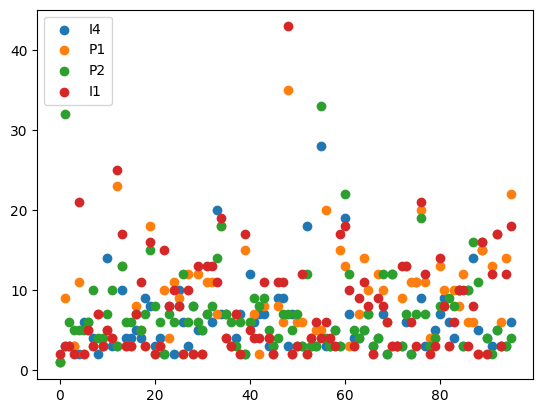

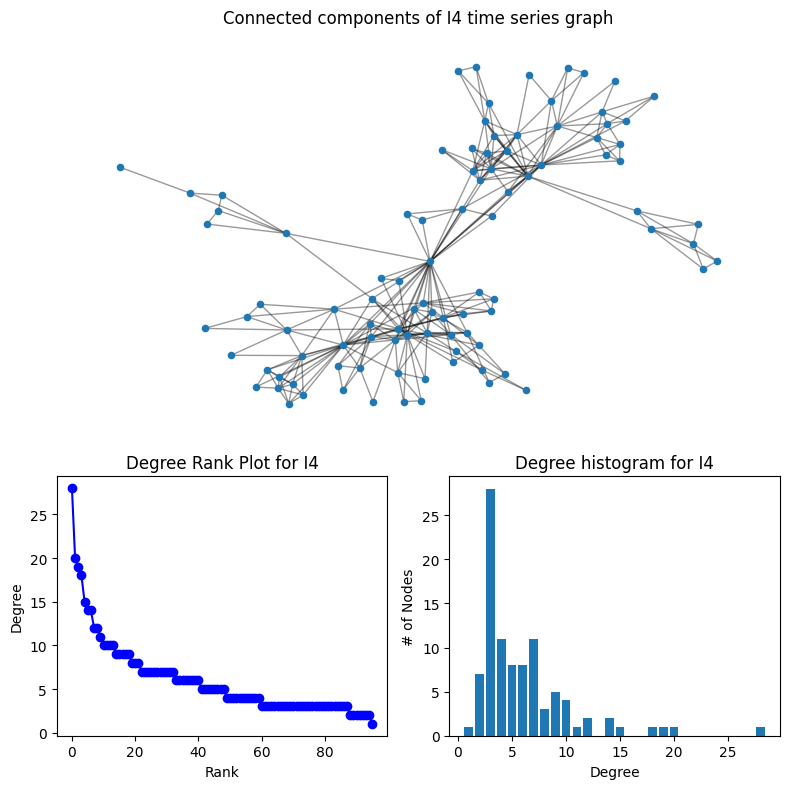

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        2           0.021053     0.012064 -0.034275              0.327586   
1        3           0.031579     0.012967 -0.037703              0.328720   
2        3           0.031579     0.012967 -0.037703              0.328720   
3        2           0.021053     0.012064 -0.034275              0.327586   
4       21           0.221053     0.148173  0.118004              0.482234   
..     ...                ...          ...       ...                   ...   
91      12           0.126316     0.135890  0.122757              0.437788   
92      17           0.178947     0.178603  0.171050              0.448113   
93       3           0.031579     0.037757  0.006063              0.314570   
94      12           0.126316     0.141189  0.134655              0.431818   
95      18           0.189474     0.184557  0.177975              0.450237   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [23]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_I4 = production_injection["I4"]
data_I4.head()
#print(data_P1.head())
data_I4.shape
series_I4 = data_I4.values
#print(series_P1)
g_I4 = visibility_graph( series_I4 )
g_I4_edges = g_I4.edges()
print(g_I4.nodes())
#print(g1.edges())
#print(g1_edges)
g_I4_edges
# Convert the graph into PyTorch geometric
pyg_graph_I4 = from_networkx(g_I4)
print(pyg_graph_I4)
# Convert the graph into PyTorch geometric
pyg_graph_I4 = from_networkx(g_I4)
print(pyg_graph_I4)
print(pyg_graph_I4.x)
print(pyg_graph_I4.y)
print("edge index")
print(pyg_graph_I4.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_I4 = to_networkx(pyg_graph_I4, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_I4 = nx.spring_layout(g_I4, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_I4, pos_I4, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_I4, pos_I4, width=4.0, alpha=0.5, edge_color="tab:blue")
# some math labels

nx.draw_networkx_labels(g_I4, pos_I4, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well I4 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_I4.png")
plt.show()
print("I4 degree", g_I4.degree)
print("I4 degree", sorted(g_I4.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()



fig = plt.figure()
ax1 = fig.add_subplot()
zipped_degree_I4 = g_I4.degree
zipped_degree_P1 = gp1.degree
zipped_degree_P2 = g_P2.degree
zipped_degree_I1 = g_I1.degree

print("unziping the degree measure")
degree_unziped_I4 = zip(*zipped_degree_I4)
print(degree_unziped_I4)
#plt.scatter(*zip(*zipped_degree_I4))
ax1.scatter(*zip(*zipped_degree_I4), label='I4')
ax1.scatter(*zip(*zipped_degree_P1), label='P1')
ax1.scatter(*zip(*zipped_degree_P2), label='P2')
ax1.scatter(*zip(*zipped_degree_I1), label='I1')
plt.legend(loc='upper left')
plt.show







degree_sequence_I4 = sorted((d for n, d in g_I4.degree()), reverse=True)
print("Degree_sequence_I4", degree_sequence_I4)
dmax_I4 = max(degree_sequence_I4)
print(dmax_I4)

fig = plt.figure("Degree of I4 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_I4.subgraph(sorted(nx.connected_components(g_I4), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of I4 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_I4, "b-", marker="o")
ax1.set_title("Degree Rank Plot for I4")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_I4, return_counts=True))
ax2.set_title("Degree histogram for I4")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_I1_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_I1.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_I1),
    EIGENVECTOR = nx.eigenvector_centrality(g_I1),
    KATZ = nx.katz_centrality_numpy(g_I1),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_I1),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_I1),
    CLUSTCOEF = nx.clustering(g_I1),
)) 

print(ts_g_I1_characteristics)


edges_df_g_I1 = nx.to_pandas_edgelist(g_I1, nodelist=labels)
print("VG_edges I1")
print(edges_df_g_I1)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Data(edge_index=[2, 734], mag=[96], num_nodes=96)
Data(edge_index=[2, 734], mag=[96], num_nodes=96)
None
None
tensor([[ 0,  1,  1,  ..., 94, 94, 95],
        [ 1,  0,  2,  ..., 95, 92, 94]])


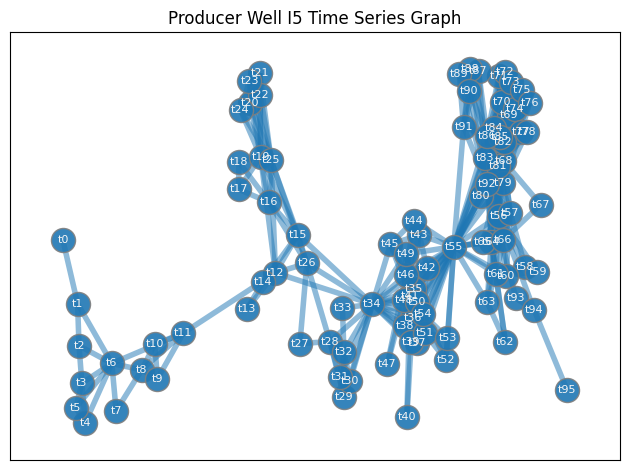

<Figure size 640x480 with 0 Axes>

I5 degree [(0, 1), (1, 3), (2, 3), (3, 4), (4, 3), (5, 3), (6, 8), (7, 2), (8, 5), (9, 3), (10, 3), (11, 5), (12, 8), (13, 2), (14, 3), (15, 7), (16, 6), (17, 3), (18, 3), (19, 11), (20, 6), (21, 5), (22, 5), (23, 6), (24, 4), (25, 10), (26, 7), (27, 2), (28, 7), (29, 5), (30, 5), (31, 5), (32, 6), (33, 2), (34, 23), (35, 13), (36, 12), (37, 6), (38, 6), (39, 12), (40, 2), (41, 15), (42, 6), (43, 6), (44, 5), (45, 5), (46, 12), (47, 2), (48, 12), (49, 5), (50, 10), (51, 10), (52, 4), (53, 4), (54, 13), (55, 36), (56, 18), (57, 9), (58, 5), (59, 3), (60, 6), (61, 9), (62, 3), (63, 5), (64, 11), (65, 5), (66, 6), (67, 2), (68, 26), (69, 16), (70, 13), (71, 9), (72, 9), (73, 10), (74, 12), (75, 8), (76, 7), (77, 11), (78, 5), (79, 8), (80, 5), (81, 11), (82, 19), (83, 8), (84, 13), (85, 17), (86, 17), (87, 5), (88, 6), (89, 4), (90, 6), (91, 7), (92, 14), (93, 2), (94, 3), (95, 1)]
I5 degree [(55, 36), (68, 26), (34, 23), (82, 19), (56, 18), (85, 17), (86, 17), (69, 16), (41, 15), (92, 14

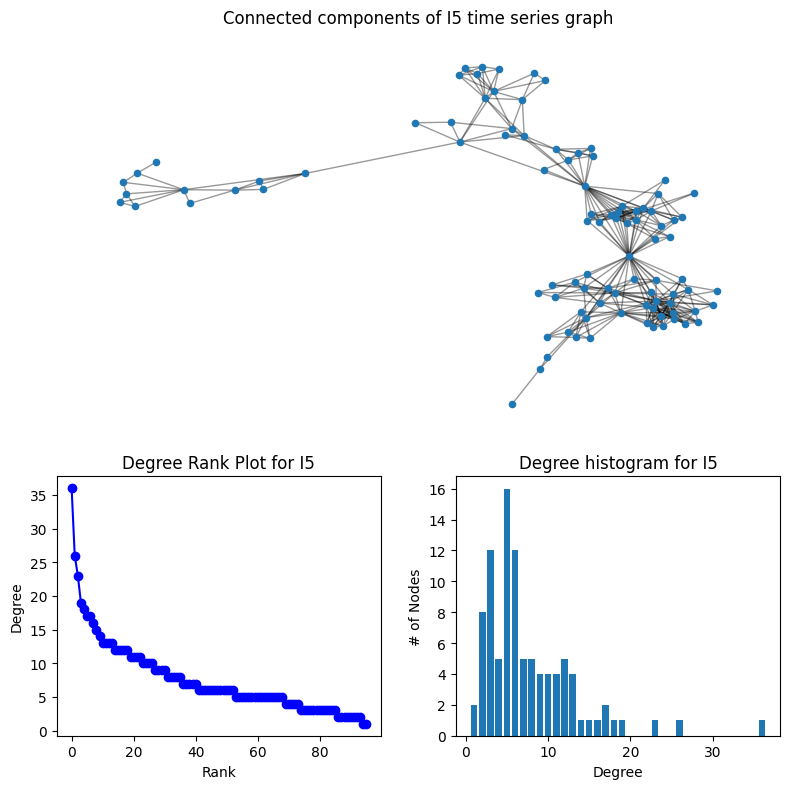

    DEGREE  DEGREE_CENTRALITY  EIGENVECTOR      KATZ  CLOSENESS_CENTRALITY  \
0        2           0.021053     0.012064 -0.034275              0.327586   
1        3           0.031579     0.012967 -0.037703              0.328720   
2        3           0.031579     0.012967 -0.037703              0.328720   
3        2           0.021053     0.012064 -0.034275              0.327586   
4       21           0.221053     0.148173  0.118004              0.482234   
..     ...                ...          ...       ...                   ...   
91      12           0.126316     0.135890  0.122757              0.437788   
92      17           0.178947     0.178603  0.171050              0.448113   
93       3           0.031579     0.037757  0.006063              0.314570   
94      12           0.126316     0.141189  0.134655              0.431818   
95      18           0.189474     0.184557  0.177975              0.450237   

    BETWEENNESS_CENTRALITY  CLUSTCOEF  
0                 0.000

In [35]:
#Construct the visibility graph form the time series for each well (production/injection)
edges = []
#print(production_df.head())
data_I5 = production_injection["I5"]
data_I5.head()
#print(data_P1.head())
data_I5.shape
series_I5 = data_I5.values
#print(series_P1)
g_I5 = visibility_graph( series_I5 )
g_I5_edges = g_I5.edges()
print(g_I5.nodes())
#print(g1.edges())
#print(g1_edges)
g_I5_edges
# Convert the graph into PyTorch geometric
pyg_graph_I5 = from_networkx(g_I5)
print(pyg_graph_I5)
# Convert the graph into PyTorch geometric
pyg_graph_I5 = from_networkx(g_I5)
print(pyg_graph_I5)
print(pyg_graph_I5.x)
print(pyg_graph_I5.y)
print(pyg_graph_I5.edge_index)
#data = Data(x=x, edge_index=edge_index) # Graph object
g_I5 = to_networkx(pyg_graph_I5, to_undirected=True)
#visualize_graph(gp1, color=pyg_graph.y)


# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
pos_I5 = nx.spring_layout(g_I5, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_I5, pos_I5, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_I5, pos_I5, width=4.0, alpha=0.5, edge_color="tab:blue")
# some math labels

nx.draw_networkx_labels(g_I5, pos_I5, labels, font_size=8, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")

plt.title("Producer Well I5 Time Series Graph")
plt.tight_layout()
#plt.axis("off")
plt.figure(linewidth=10, edgecolor="#04253a")
plt.savefig("ts_graph_I5.png")
plt.show()
print("I5 degree", g_I5.degree)
print("I5 degree", sorted(g_I5.degree, key=lambda x: x[1], reverse=True))
#fig.savefig("ts_graph_P1.png", edgecolor=fig.get_edgecolor())
plt.show()



degree_sequence_I5 = sorted((d for n, d in g_I5.degree()), reverse=True)
print("Degree_sequence_I5", degree_sequence_I5)
dmax_I5 = max(degree_sequence_I5)
print(dmax_I5)

fig = plt.figure("Degree of I5 time series graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = g_I5.subgraph(sorted(nx.connected_components(g_I5), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of I5 time series graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence_I5, "b-", marker="o")
ax1.set_title("Degree Rank Plot for I5")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence_I5, return_counts=True))
ax2.set_title("Degree histogram for I5")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()



ts_g_I1_characteristics = pd.DataFrame(dict(
    DEGREE = dict(g_I1.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g_I1),
    EIGENVECTOR = nx.eigenvector_centrality(g_I1),
    KATZ = nx.katz_centrality_numpy(g_I1),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g_I1),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g_I1),
    CLUSTCOEF = nx.clustering(g_I1),
)) 

print(ts_g_I1_characteristics)


edges_df_g_I1 = nx.to_pandas_edgelist(g_I1, nodelist=labels)
print("VG_edges I1")
print(edges_df_g_I1)


Now, getting the graph having as nodes each one of the wells instead of each one of the temporal points

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Data(edge_index=[2, 30], mag=[9], num_nodes=9)
Data(edge_index=[2, 30], mag=[9], num_nodes=9)
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6,
         7, 7, 7, 8, 8, 8],
        [1, 2, 3, 0, 2, 3, 1, 3, 0, 2, 4, 0, 1, 5, 3, 5, 4, 6, 3, 7, 8, 5, 7, 8,
         6, 8, 5, 7, 5, 6]])


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


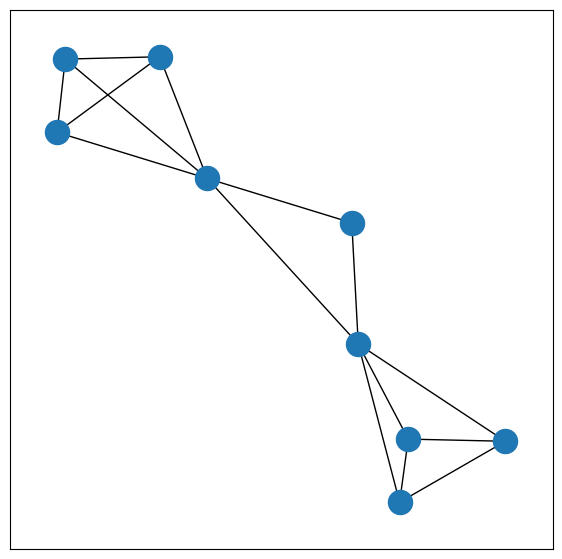

In [21]:
production_injection_d1 = production_injection3[1]
production_injection_d1.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_1 = production_injection3[1]
data_1.head(20)
#print(data_P1.head())
data_1.shape
series_1 = data_1.values
#print(series_P1)
g_1 = visibility_graph( series_1 )
g_1_edges = g_1.edges()
print(g_1.nodes())
#print(g1.edges())
#print(g1_edges)
g_1_edges
# Convert the graph into PyTorch geometric
pyg_graph_1 = from_networkx(g_1)
print(pyg_graph_1)
# Convert the graph into PyTorch geometric
pyg_graph_1 = from_networkx(g_1)
print(pyg_graph_1)
print(pyg_graph_1.edge_index)
g_1 = to_networkx(pyg_graph_1, to_undirected=True)
visualize_graph(g_1, color=pyg_graph_1.y)

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Data(edge_index=[2, 32], mag=[9], num_nodes=9)
Data(edge_index=[2, 32], mag=[9], num_nodes=9)
tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 6,
         6, 6, 7, 7, 7, 8, 8, 8],
        [1, 2, 3, 5, 0, 2, 3, 1, 3, 0, 2, 4, 0, 1, 5, 3, 5, 4, 6, 0, 3, 7, 8, 5,
         7, 8, 6, 8, 5, 7, 5, 6]])


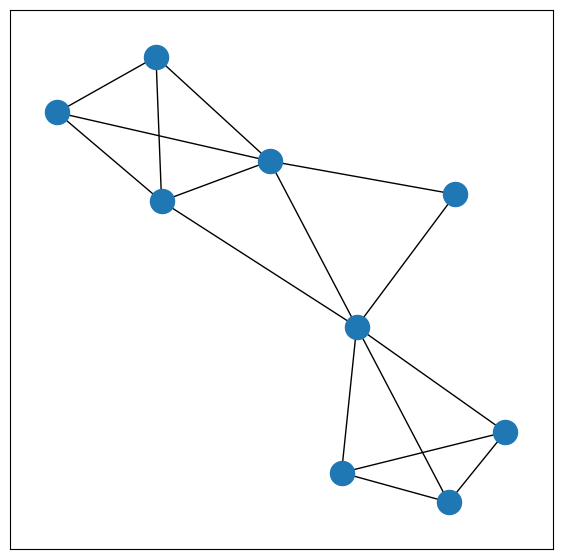

In [22]:
production_injection_d1 = production_injection3[1]
production_injection_d1.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_2 = production_injection3[2]
data_2.head(20)
#print(data_P1.head())
data_2.shape
series_2 = data_2.values
#print(series_P1)
g_2 = visibility_graph( series_2 )
g_2_edges = g_2.edges()
print(g_2.nodes())
#print(g1.edges())
#print(g1_edges)
g_2_edges
# Convert the graph into PyTorch geometric
pyg_graph_2 = from_networkx(g_2)
print(pyg_graph_2)
# Convert the graph into PyTorch geometric
pyg_graph_2 = from_networkx(g_2)
print(pyg_graph_2)
print(pyg_graph_2.edge_index)
g_2 = to_networkx(pyg_graph_2, to_undirected=True)
visualize_graph(g_2, color=pyg_graph_2.y)

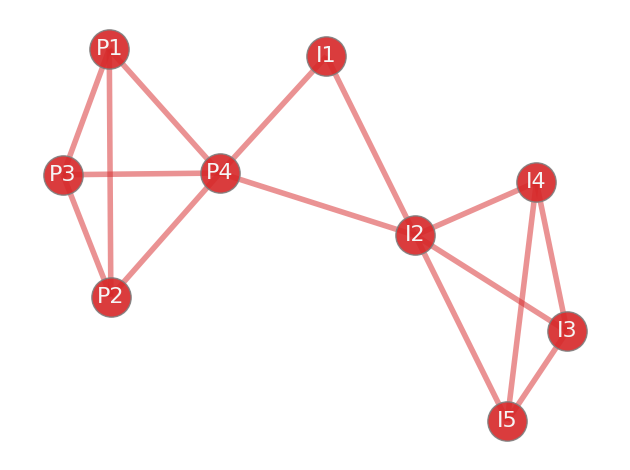

In [23]:
# Graph at time t=1
# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos_1 = nx.spring_layout(g_1, seed=3113794652)  # positions for all nodes
#pos_2 = nx.spring_layout(g_2, seed=3113794652)  # positions for all nodes

nx.draw_networkx_nodes(g_1, pos_1, node_color="tab:red", **options)
#nx.draw_networkx_nodes(g_2, pos_2, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_1, pos_1, width=4.0, alpha=0.5, edge_color="tab:red")
#nx.draw_networkx_edges(g_2, pos_2, width=4.0, alpha=0.5, edge_color="tab:blue")
# some math labels
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_1, pos_1, labels, font_size=16, font_color="whitesmoke")
#nx.draw_networkx_labels(g_2, pos_2, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

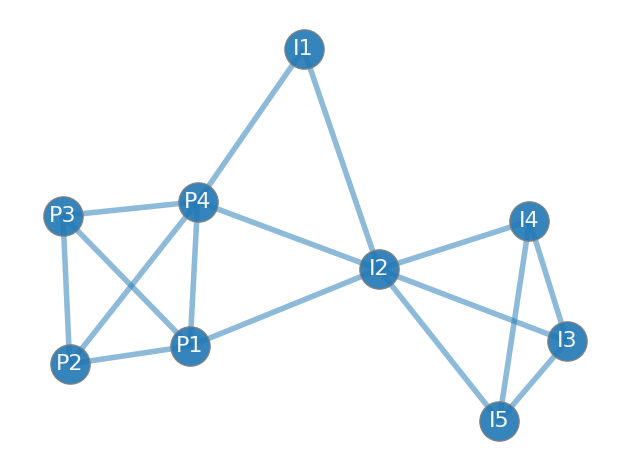

In [24]:
# Graph at time t=2
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos = nx.spring_layout(g_2, seed=3113794652)  # positions for all nodes
nx.draw_networkx_nodes(g_2, pos, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_2, pos, width=4.0, alpha=0.5, edge_color="tab:blue")
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_2, pos, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

Data(edge_index=[2, 32], mag=[9], num_nodes=9)


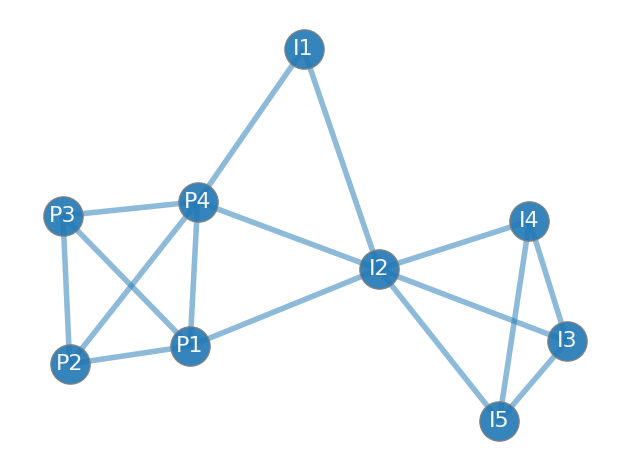

In [25]:
#Graph at time t=3
production_injection_d3 = production_injection3[3]
production_injection_d3.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_3 = production_injection3[3]
#data_3.head(20)
#print(data_P1.head())
#data_2.shape
series_3 = data_3.values
#print(series_P1)
g_3 = visibility_graph( series_3 )
g_3_edges = g_3.edges()
#print(g_3.nodes())
#print(g1.edges())
#print(g1_edges)
g_3_edges
# Convert the graph into PyTorch geometric
pyg_graph_3= from_networkx(g_3)
print(pyg_graph_3)
# Convert the graph into PyTorch geometric
pyg_graph_3 = from_networkx(g_3)
#print(pyg_graph_3)
#print(pyg_graph_3.edge_index)
g_3 = to_networkx(pyg_graph_3, to_undirected=True)
#visualize_graph(g_3, color=pyg_graph_3.y)
# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos_3 = nx.spring_layout(g_3, seed=3113794652)  # positions for all nodes
nx.draw_networkx_nodes(g_3, pos_3, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_3, pos_3, width=4.0, alpha=0.5, edge_color="tab:blue")
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_3, pos_3, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

Data(edge_index=[2, 34], mag=[9], num_nodes=9)


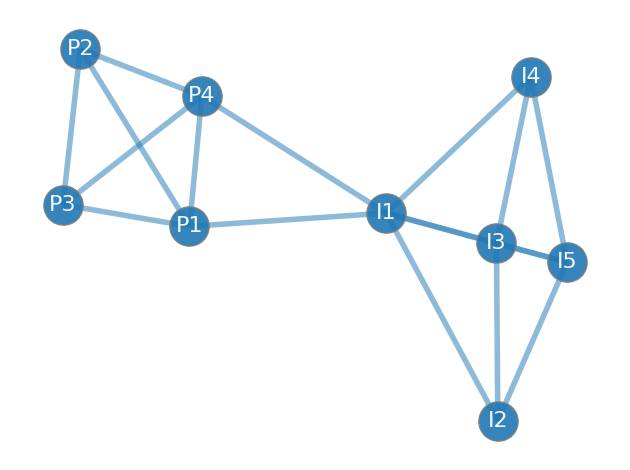

In [26]:
#Graph at time t=4
production_injection_d4 = production_injection3[4]
#production_injection_d4.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_4 = production_injection3[4]
#data_3.head(20)
#print(data_P1.head())
#data_2.shape
series_4 = data_4.values
#print(series_P1)
g_4 = visibility_graph( series_4 )
g_4_edges = g_4.edges()
#print(g_3.nodes())
#print(g1.edges())
#print(g1_edges)
g_4_edges
# Convert the graph into PyTorch geometric
pyg_graph_4= from_networkx(g_4)
print(pyg_graph_4)
# Convert the graph into PyTorch geometric
pyg_graph_4 = from_networkx(g_4)
#print(pyg_graph_3)
#print(pyg_graph_3.edge_index)
g_4 = to_networkx(pyg_graph_4, to_undirected=True)
#visualize_graph(g_3, color=pyg_graph_3.y)
# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos_4 = nx.spring_layout(g_4, seed=3113794652)  # positions for all nodes
nx.draw_networkx_nodes(g_4, pos_4, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_4, pos_4, width=4.0, alpha=0.5, edge_color="tab:blue")
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_4, pos_4, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

Data(edge_index=[2, 32], mag=[9], num_nodes=9)


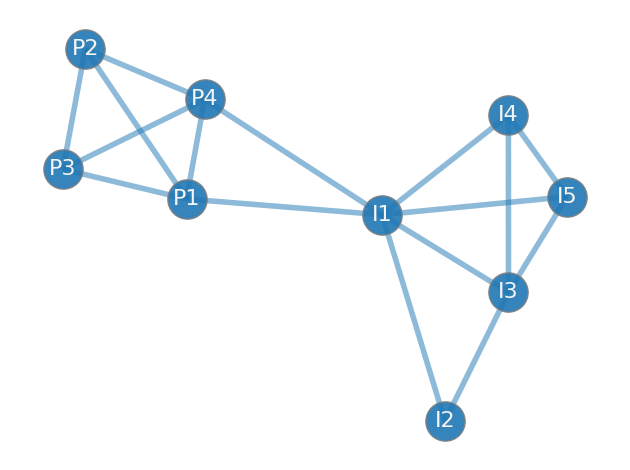

In [27]:
#Graph at time t=48
production_injection_d48 = production_injection3[48]
#production_injection_d4.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_48 = production_injection3[48]
#data_3.head(20)
#print(data_P1.head())
#data_2.shape
series_48 = data_48.values
#print(series_P1)
g_48 = visibility_graph( series_48 )
g_48_edges = g_48.edges()
#print(g_3.nodes())
#print(g1.edges())
#print(g1_edges)
g_48_edges
# Convert the graph into PyTorch geometric
pyg_graph_48= from_networkx(g_48)
print(pyg_graph_48)
# Convert the graph into PyTorch geometric
pyg_graph_48 = from_networkx(g_48)
#print(pyg_graph_3)
#print(pyg_graph_3.edge_index)
g_48 = to_networkx(pyg_graph_48, to_undirected=True)
#visualize_graph(g_3, color=pyg_graph_3.y)
# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos_48 = nx.spring_layout(g_48, seed=3113794652)  # positions for all nodes
nx.draw_networkx_nodes(g_48, pos_48, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_48, pos_48, width=4.0, alpha=0.5, edge_color="tab:blue")
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_48, pos_48, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

Data(edge_index=[2, 32], mag=[9], num_nodes=9)


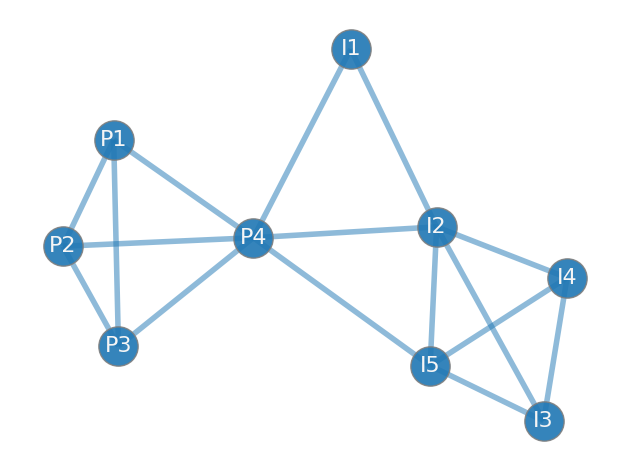

In [28]:
#Graph at time t=5
production_injection_d5 = production_injection3[5]
#production_injection_d4.head(30)
#Construct the visibility graph having as node each well (production/injection)
edges_w = []
#print(production_df.head())
data_5 = production_injection3[5]
#data_3.head(20)
#print(data_P1.head())
#data_2.shape
series_5 = data_5.values
#print(series_P1)
g_5 = visibility_graph( series_5 )
g_5_edges = g_5.edges()
#print(g_3.nodes())
#print(g1.edges())
#print(g1_edges)
g_5_edges
# Convert the graph into PyTorch geometric
pyg_graph_5= from_networkx(g_5)
print(pyg_graph_5)
# Convert the graph into PyTorch geometric
pyg_graph_5 = from_networkx(g_5)
#print(pyg_graph_3)
#print(pyg_graph_3.edge_index)
g_5 = to_networkx(pyg_graph_5, to_undirected=True)
#visualize_graph(g_3, color=pyg_graph_3.y)
# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
pos_5 = nx.spring_layout(g_5, seed=3113794652)  # positions for all nodes
nx.draw_networkx_nodes(g_5, pos_5, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(g_5, pos_5, width=4.0, alpha=0.5, edge_color="tab:blue")
labels = {}
labels[0] = r"P1"
labels[1] = r"P2"
labels[2] = r"P3"
labels[3] = r"P4"
labels[4] = r"I1"
labels[5] = r"I2"
labels[6] = r"I3"
labels[7] = r"I4"
labels[8] = r"I5"
nx.draw_networkx_labels(g_5, pos_5, labels, font_size=16, font_color="whitesmoke")


plt.tight_layout()
plt.axis("off")
plt.show()

Building the RNN, GRU and LSTM architectures for time series

In [29]:
import plotly.graph_objs as go
from plotly.offline import iplot

pi_df = production_injection
pi_df = pi_df.iloc[:-23]
pi_df = pi_df.set_index(['Date'])
print(pi_df.head())


def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        #y=df.value,
        y=df,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Production Rate", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    


                     P1          P2          P3           P4           I1  \
Date                                                                        
01/01/2016     0.000000    0.000000    0.000000     0.000000     0.000000   
01/02/2016  3030.190674  180.331818  180.511932  2409.921631   284.662415   
02/01/2016  1034.125977   92.040901  254.523758  1092.091431   284.674286   
03/02/2016  1242.952759   79.237770  357.866791  1284.484741   284.674286   
04/02/2016  2894.078125   80.246880  343.474640  1714.793823  2040.237061   

                     I2          I3          I4          I5  
Date                                                         
01/01/2016     0.000000    0.000000    0.000000    0.000000  
01/02/2016  1824.588013  278.588287  270.050903  769.642883  
02/01/2016  1824.665039  278.600098  270.062286  769.675415  
03/02/2016  1824.665039  278.600098  270.062286  769.675415  
04/02/2016  1067.610962  792.954712  259.661194  400.257812  


In [41]:
#print(pi_df.tail(30))

pi_df.index = pd.to_datetime(pi_df.index)
if not pi_df.index.is_monotonic_increasing:
    pi_df = pi_df.sort_index()
    
#pi_df = pi_df.rename(columns={'PJME_MW': 'value'})
plot_dataset(pi_df['P1'], title='Production Rate P1')


In [31]:
p_i_df = production_injection
p_i_df = p_i_df.iloc[:-23]
print(p_i_df.head())
p_i_df2 = p_i_df.reset_index()
print(p_i_df2.head())
plot_dataset(p_i_df2['P1'], title='Production Rates P1')


         Date           P1          P2          P3           P4           I1  \
0  01/01/2016     0.000000    0.000000    0.000000     0.000000     0.000000   
1  01/02/2016  3030.190674  180.331818  180.511932  2409.921631   284.662415   
2  02/01/2016  1034.125977   92.040901  254.523758  1092.091431   284.674286   
3  03/02/2016  1242.952759   79.237770  357.866791  1284.484741   284.674286   
4  04/02/2016  2894.078125   80.246880  343.474640  1714.793823  2040.237061   

            I2          I3          I4          I5  
0     0.000000    0.000000    0.000000    0.000000  
1  1824.588013  278.588287  270.050903  769.642883  
2  1824.665039  278.600098  270.062286  769.675415  
3  1824.665039  278.600098  270.062286  769.675415  
4  1067.610962  792.954712  259.661194  400.257812  
   index        Date           P1          P2          P3           P4  \
0      0  01/01/2016     0.000000    0.000000    0.000000     0.000000   
1      1  01/02/2016  3030.190674  180.331818  180.51

In [32]:
plot_dataset(pi_df['P2'], title='Production Rate P2')

In [33]:
plot_dataset(pi_df['P3'], title='Production Rate P3')

In [34]:
plot_dataset(pi_df['P4'], title='Production Rate P4')

In [35]:
plot_dataset(pi_df['I1'], title='Injection Rate I1')

In [36]:
plot_dataset(pi_df['I2'], title='Injection Rate I2')

In [37]:
plot_dataset(pi_df['I3'], title='Injection Rate I3')

In [38]:
plot_dataset(pi_df['I4'], title='Injection Rate I4')

In [39]:
plot_dataset(pi_df['I5'], title='Injection Rate I5')

In [66]:
import plotly.express as px

fig_histo = px.scatter(pi_df['P1'], x=pi_df.index, y=['P1'])
#fig_histo.update_traces(width=1000)
iplot(fig_histo)

In [73]:
import plotly.express as px
fig_all = px.line(pi_df, x=pi_df.index, y=pi_df.columns,
 #             hover_data={pi_df.index: "|%B %d, %Y"},
              title='Production vs Injection')
fig_all.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
   # tickformat="%Y")
fig_all.show()